In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from cmap import Colormap
import matplotlib.ticker as ticker
import numpy as np
from convergence.figures import add_pvalue_bracket
# Set arial as the default font
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'


## Functions

In [49]:

def plot_boxplots(
        df_plot,
        x="cluster",
        x_order=[],
        y="cka",
        hue="partition_value",
        hue_order=[],
        hue_palette=[],
        hue_filter="partition",
        hue_filter_values=[],
        cols="modality",
        cols_order=["Intersubject", "Vision", "Language"],
        ylim=(0.01, 0.235),
        legend_fontsize=9,
        legend_loc=(0, 1.03),
):

    fig, axes = plt.subplots(3, 1, figsize=(len(cols_order)*3, 12), gridspec_kw={"hspace": 0.2})
    for i, (ax, col) in enumerate(zip(axes, cols_order)):
        legend = i == 0
        ax.set_title(col, pad=-20)
        sns.boxplot(
            data=df_plot[df_plot[hue_filter].isin(hue_filter_values) & (df_plot[cols] == col)],
            x=x,
            y=y,
            hue=hue,
            order=x_order,
            hue_order=hue_order,
            ax=ax,
            legend=legend,
            palette=hue_palette,
        )
        ax.set_ylim(ylim)
        # Remove the spacer legend entry
        if legend:
            handles, labels = ax.get_legend_handles_labels()
            filtered = [(h, l) for h, l in zip(handles, labels) if l != ""]
            ax.legend(*zip(*filtered), title='', fontsize=legend_fontsize, loc="upper left", bbox_to_anchor=legend_loc)
        ax.set_xlabel("")
        ax.set_ylabel("Alignment (CKA)")
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
        # Major locator of 5% but avoid 0.0
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.set_yticks([0.05, 0.1, 0.15, 0.2])

        #ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        
        

        ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=-100)
        sns.despine(ax=ax)
    return fig, axes
        


def scatter_plots(
    df,
    hue,
    x="cca_1",
    y="cca_2",
    rois=["visual_cortex", "ventral_hub", "dorsal_hub"],
    s=5,
    axis_names=["CCA 1", "CCA 2"],
    palettes={},
    hue_orders={},
    histograms=False,
    margin=0.2,
    transpose=False,
):
    if isinstance(hue, str):
        hue = [hue]

    n_rows = len(hue)
    n_columns = len(rois)

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(s * n_columns, s * n_rows))

    if transpose:
        axes = axes.T

    for i, roi in enumerate(rois):
        df_scatter = df.query(f"roi=='{roi}'")[[x, y] + hue].copy().sample(frac=1)
        
        # Normalize x, y
        df_scatter[x] -= df_scatter[x].min()
        df_scatter[x] /= df_scatter[x].max()
        df_scatter[y] -= df_scatter[y].min()
        df_scatter[y] /= df_scatter[y].max()

        for j, h in enumerate(hue):
            palette = palettes.get(h)
            hue_order = hue_orders.get(h)
            
            ax = axes[j, i]
            legend = i == 0 #n_columns - 1
            sns.scatterplot(data=df_scatter, x=x, y=y, hue=h, ax=ax, legend=legend, palette=palette, hue_order=hue_order)
            if legend:
                ax.legend(
                    loc="center left",
                    bbox_to_anchor=(1, 0.5),
                    ncol=1,
                    title=h.replace("_", " ").title(),
                )
            sns.despine(ax=ax)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_title(roi.replace("_", " ").title())
            ax.set_xlabel(axis_names[0])
            ax.set_ylabel(axis_names[1])
            ax.axis("equal")
            ax.set_xlim(-margin, 1 + margin)
            ax.set_ylim(-margin, 1 + margin)
            #Add an auxiliary histogram to the x axis with a distplots
            #Add the axis to the bottom
            if j > 0 and histograms:
                big_position = ax.get_position()
                # Small axis (x0, y0, x1, y1)
                small_position = [big_position.x0, big_position.y0, big_position.width, big_position.height/10]
                ax_hist = fig.add_axes(small_position, frame_on=True)
                sns.kdeplot(data=df_scatter, x=x, ax=ax_hist, color="gray", hue=h, fill=True, common_norm=False, legend=False, zorder=-1000, hue_order=hue_order, palette=palette)
                # Only let the x axis visible
                ax_hist.axis("off")
                # Reverse the y axis

    if transpose:
        axes = axes.T

    return fig, axes

def create_spacer_rows(cluster_order):
    # Create a spacer row for each cluster
    spacers = pd.DataFrame({
        "cluster": cluster_order,
        "cka": [-10]*len(cluster_order),
        "partition_value": [""]*len(cluster_order),  # single spacer category
    })
    return spacers


## Data

In [50]:
data_folder = Path("data/dimensions")

filename_projections = data_folder / "ccaa_projections.parquet"
filename_subsets_intersubject = data_folder / Path("nsd_alignment_intersubject_partitions.parquet")
filename_subsets_models = data_folder / Path("nsd_alignment_models_partitions.parquet")
filename_hcp = "data/hcp3.csv"

output = Path("figure_dimensions")
output.mkdir(exist_ok=True)


In [51]:
objects_boxes = pd.read_parquet("data/dimensions/detected_objects.parquet")
labels = ["person", "giraffe", "cat", "zebra", "horse", "bird", "sheep", "elephant", "bear", "dog", "person"]
#objects_boxes_filtered = objects_boxes.query("label in @labels and percent_area>0.7")
objects_boxes_filtered = objects_boxes.query("percent_area>0.6")
df_objectes_g = objects_boxes_filtered.groupby("nsd_id").size().reset_index(name="total_area")
df_objectes_g2 = objects_boxes.groupby("nsd_id").size().reset_index(name="n_objects")
df_objectes_g2 = df_objectes_g2.query("n_objects<3")
df_objectes_g = df_objectes_g.merge(df_objectes_g2, on="nsd_id", how="inner")
object_dominated = df_objectes_g.query("total_area>=1").nsd_id.unique()

## Scatter

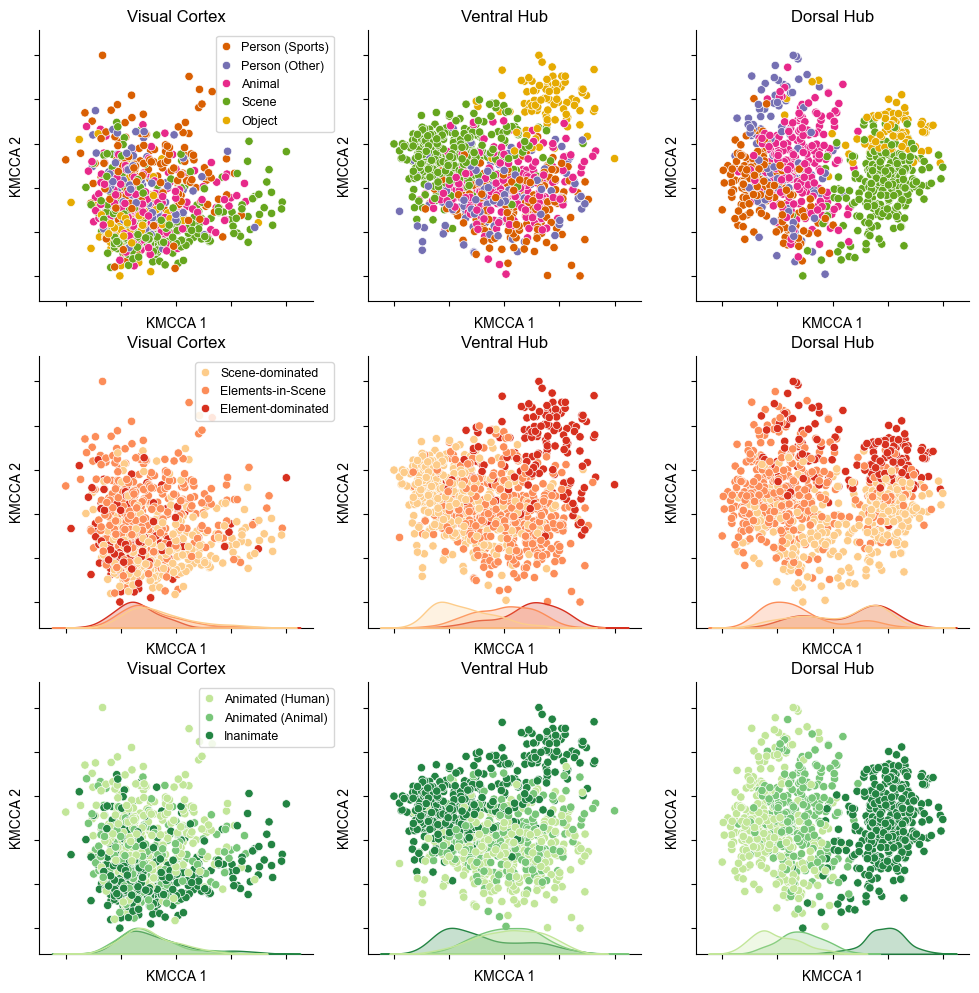

In [52]:
df = pd.read_parquet(filename_projections)
df["biology"] = "Inanimate"
df.loc[df["image_category"].isin(["animal"]), "biology"] = "Animated (Animal)"
df.loc[df["image_category"].isin(["person_action", "sports"]) & df.life, "biology"] = "Animated (Human)"
biology_palette = {
    "Animated (Human)": "C0",
    "Animated (Animal)": "C1",
    "Inanimate": "C2",
}


hue = ["category2", "scene_dominated2", "biology"]
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

df["scene_dominated2"] = df["scene_dominated"]
df.loc[df["category2"] == "object", "scene_dominated2"] = "object-dominated"
df.loc[df.nsd_id.isin(object_dominated), "scene_dominated2"] = "object-dominated"
df.scene_dominated2 = df.scene_dominated2.str.capitalize()
#df.loc[df["category2"] == "scene", "scene_dominated2"] = "scene-dominated"

scene_mapping = {
    "Scene-dominated": "Scene-dominated",
    "Object-in-scene": "Elements-in-Scene",
    "Object-dominated": "Element-dominated",
}
df.scene_dominated2 = df.scene_dominated2.map(scene_mapping)

scene_palette = {
    "Scene-dominated": "C0",
    "Elements-in-Scene": "C1",
    "Element-dominated": "C2",
}

category2_mapping = {
    "sports": "Person (Sports)",
    "person_action": "Person (Other)",
    "animal": "Animal",
    "scene": "Scene",
    "object": "Object",
}
df.category2 = df.category2.map(category2_mapping)
# colorbrewer:accent_5
palettes = {"category2": list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1])),
            "scene_dominated2": list(Colormap('colorbrewer:orrd_4')([0.33, 0.66, 1])),
            "biology":  list(Colormap('colorbrewer:ylgn_4')([0.33, 0.66, 1]))}
hue_order = {"biology": list(biology_palette.keys()),
             "scene_dominated2": list(scene_palette.keys()),
                "category2": list(category2_mapping.values())}
fig, axes = scatter_plots(df=df, hue=hue, rois=rois, palettes=palettes, hue_orders=hue_order, histograms=True, axis_names=["KMCCA 1", "KMCCA 2"], margin=0.12, s=12/3)

# Reduce horizontal space between color legend and text labels in legend
axes[0, 0].legend(title="", loc="upper right", ncol=1, fontsize=9, bbox_to_anchor=(1.1, 1), handlelength=0.8)
axes[1, 0].legend(title="", loc="upper right", ncol=1, fontsize=9, bbox_to_anchor=(1.1, 1), handlelength=0.8)
axes[2, 0].legend(title="", loc="upper right", ncol=1, fontsize=9, bbox_to_anchor=(1.1, 1), handlelength=0.8)

# for ax in axes.flatten():
#     ax.set_xlabel("KMCCA 1", fontsize=12)
#     ax.set_ylabel("KMCCA 2", fontsize=12)
    
#fig.savefig(output / "figure_dimensions_cmaps.pdf", bbox_inches="tight", dpi=300)


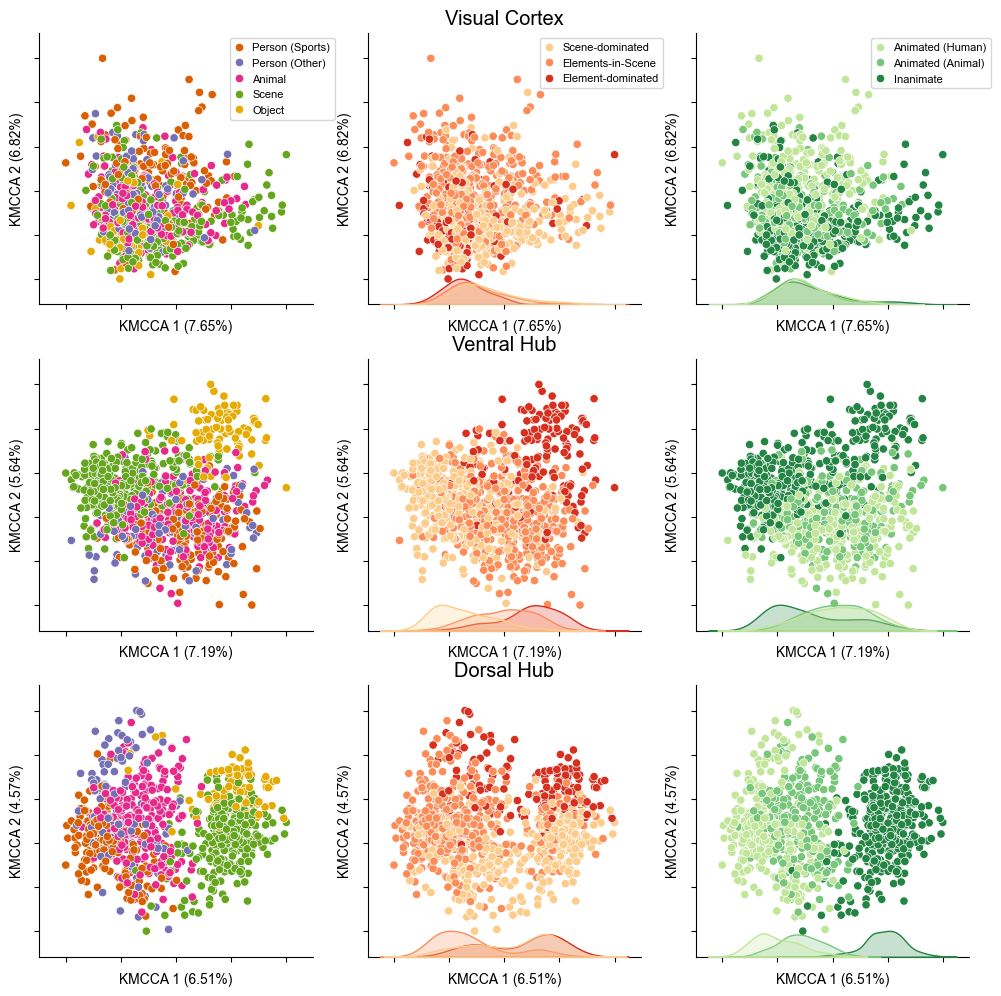

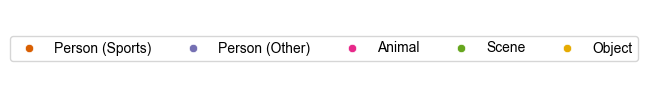

In [281]:
fig, axes = scatter_plots(df=df, hue=hue, rois=rois, palettes=palettes, 
                          hue_orders=hue_order, histograms=True,
                           axis_names=["KMCCA 1", "KMCCA 2"], margin=0.12, s=12/3, transpose=True)

# Reduce horizontal space between color legend and text labels in legend
axes[0, 0].legend(title="", loc="upper right", ncol=1, fontsize=8, bbox_to_anchor=(1.1, 1), handlelength=0.8)
axes[0, 1].legend(title="", loc="upper right", ncol=1, fontsize=8, bbox_to_anchor=(1.1, 1), handlelength=0.8)
axes[0, 2].legend(title="", loc="upper right", ncol=1, fontsize=8, bbox_to_anchor=(1.1, 1), handlelength=0.8)



#Visual Cortex: 7.65%, 6.82%
#Ventral Hub: 7.19%, 5.64%
# Dorsal Hub: 6.51%, 4.57%

shared_variances = [
    ["7.65%", "6.82%"],
    ["7.19%", "5.64%"],
    ["6.51%", "4.57%"],
]

for i in range(3):
    axes[i, 0].set_title("")
    axes[i, 2].set_title("")
    # change fontsize to x-large to i, 1
    axes[i, 1].set_title(rois[i].replace("_", " ").title(), fontsize="x-large")

    for j in range(3):
        axes[i, j].set_xlabel(f"KMCCA 1 ({shared_variances[i][0]})")
        axes[i, j].set_ylabel(f"KMCCA 2 ({shared_variances[i][1]})")

#fig.savefig(output / "figure_dimensions_cmaps_transpose.pdf", bbox_inches="tight", dpi=300, transparent=True)

# Get legend of axes[0, 0] and copy it to a new figure
fig_legend, ax_legend = plt.subplots(figsize=(3, 1))
handles, labels = axes[0, 0].get_legend_handles_labels()
# Remove the empty label
ax_legend.legend(handles, labels, loc="center", title="", ncol=5)
ax_legend.axis("off")
fig_legend.savefig(output / "figure_dimensions_cmaps_legend.pdf", bbox_inches="tight", dpi=300, transparent=True)


In [ ]:
rois_detail = ["V1", "V2", "V3", "V4", "PHA1", "PHA2", "VMV1", "VMV2",  "FST", "V4t", "MST", "TPOJ2"]
hue_order_cat = ["Person (Sports)", "Person (Other)", "Animal", "Scene", "Object"]
palette = list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1]))
fig, axes = plt.subplots(3, 4, figsize=(12, 9), gridspec_kw={"hspace": 0.2, "wspace": 0.1})
axes_flatten = axes.flatten()


for i, roi in enumerate(rois_detail):
    ax = axes_flatten[i]
    df_scatter = df.query(f"roi=='{roi}'").copy().sample(frac=1)
    sns.scatterplot(data=df_scatter, x="cca_1", y="cca_2", hue="category2", ax=ax, legend=False, palette=palette, hue_order=hue_order_cat)
    sns.despine(ax=ax)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(roi)
    ax.set_xlabel("")
    ax.set_ylabel("")

axes[1,0].invert_yaxis()
axes[1,1].invert_yaxis()
axes[1,2].invert_yaxis()

for i in range(3):
    axes[i, 0].set_ylabel("KMCCA 2")
    axes[-1, i].set_xlabel("KMCCA 1")
    axes[-1, -1].set_xlabel("KMCCA 1")

fig.savefig(output / "figure_dimensions_cmaps_rois_detail.pdf", bbox_inches="tight", dpi=300, transparent=True)


In [ ]:
# Make a legend. 1 row. 

In [ ]:
# Plot df dorsal hub, animation partition, only for a small figure in the paper
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
df_dh = df.query("roi=='dorsal_hub'").sample(frac=0.75).copy()

# cca_1 and cca_2 normalize to 0-1
df_dh["cca_1"] -= df_dh["cca_1"].min()
df_dh["cca_1"] /= df_dh["cca_1"].max()
df_dh["cca_2"] -= df_dh["cca_2"].min()
df_dh["cca_2"] /= df_dh["cca_2"].max()

sns.scatterplot(data=df_dh, x="cca_1", y="cca_2", hue="biology", ax=ax, palette=palettes["biology"], hue_order=hue_order["biology"], legend=False)
sns.despine(ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")
#ax.set_xticks([])
#ax.set_xticks([0.25, 0.5, 0.75, 1])
#ax.set_yticks([0.25, 0.5, 0.75, 1])
#ax.set_ylim(0, 1)
#ax.set_xlim(0, 1)
fig.savefig(output / "figure_dimensions_cmaps_dh_small.pdf", bbox_inches="tight", dpi=300, transparent=True)



In [ ]:
df_partitions = df.query("roi=='ventral_hub'").copy()
df_partitions["binary_scene_dominated"] = df_partitions["scene_dominated2"]
cut = df_partitions.query("binary_scene_dominated == 'Elements-in-Scene'").cca_1.quantile(0.5)

df_partitions.loc[(df_partitions["cca_1"] < cut) & (df_partitions["scene_dominated2"] == "Elements-in-Scene"), "binary_scene_dominated"] = "Element-dominated"
df_partitions.loc[(df_partitions["cca_1"] >= cut) & (df_partitions["scene_dominated2"] == "Elements-in-Scene"), "binary_scene_dominated"] = "Scene-dominated"

df_partitions["binary_biology"] = df_partitions["biology"]
df_partitions.binary_biology = df_partitions.binary_biology.str.split(" ").str[0]
df_partitions = df_partitions[["nsd_id", "biology", "binary_biology", "scene_dominated2", "binary_scene_dominated"]]
df_partitions = df_partitions.rename(columns={"scene_dominated2": "scene_dominated"})
df_partitions = df_partitions.drop_duplicates("nsd_id")
#df_partitions.to_csv("partitions_subsets_alignment.csv", index=False)


In [ ]:
from sklearn.metrics import silhouette_score

roi = "visual_cortex"
clustering = "category2"
for roi in rois:
    for clustering in hue:
        df_roi = df.query("roi==@roi")[["cca_1", "cca_2", clustering]]
        print(roi, clustering, round(silhouette_score(df_roi[["cca_1", "cca_2"]], df_roi[clustering]), 2))



In [ ]:
cluster_rois = {
    'Visual Cortex': ['V1', 'V2', 'V3', 'V4'],
    'Ventral Hub': ['PHA1', "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
}
order = list(cluster_rois.keys())
cluster_rois = {v : k for k, values in cluster_rois.items() for v in values}

In [57]:
df_models = pd.read_parquet(filename_subsets_models).query("cka < 1 and cka>-0.005")
# Modality is language when ends with -coco else visual
df_models["modality"] = df_models["model"].apply(lambda x: "Language" if x.endswith("coco") else "Vision")
df_models = df_models.groupby(["modality", "model", "partition", "partition_value", "subject", "roi"]).cka.max().reset_index()
df_models = df_models.groupby(["modality", "subject", "partition", "partition_value", "roi"]).cka.mean().reset_index()

df_intersubject = pd.read_parquet(filename_subsets_intersubject).query("cka < 1 and cka > -0.005")
df_subsets_intersubject = df_intersubject.groupby(["subject_i", "roi", "partition", "partition_value"]).cka.mean().reset_index()
df_subsets_intersubject["modality"] = "Intersubject"
df_subsets_intersubject = df_subsets_intersubject.rename(columns={"subject_i": "subject"})
df_subsets = pd.concat([df_subsets_intersubject, df_models], ignore_index=True)
df_hcp = pd.read_csv(filename_hcp)
df_subsets = df_subsets.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], on="roi", how="inner")
df_subsets["cluster"] = df_subsets["name"].map(cluster_rois).fillna("Other")
df_subsets.partition_value = df_subsets.partition_value.str.capitalize()
df_subsets.partition_value = df_subsets.partition_value.str.replace("human", "Human")
df_subsets.partition_value = df_subsets.partition_value.str.replace("animal", "Animal")
df_subsets.partition = df_subsets.partition.str.replace("_", " ").str.capitalize()
df_subsets.partition_value = df_subsets.partition_value.replace({"All": "All Scenes"})
df_subsets_clusters = df_subsets.query("cluster!='Other'")
df_subsets_clusters = df_subsets_clusters.groupby(["modality",  "cluster",  "partition", "partition_value", "subject"]).cka.mean().reset_index()
df_subsets_clusters = df_subsets_clusters.sort_values(["modality", "cluster", "partition", "partition_value", "subject"]).reset_index(drop=True)
df_subsets_clusters

,modality,cluster,partition,partition_value,subject,cka
0,Intersubject,Dorsal Hub,All scenes,All Scenes,1,0.200126
1,Intersubject,Dorsal Hub,All scenes,All Scenes,2,0.215413
2,Intersubject,Dorsal Hub,All scenes,All Scenes,3,0.155855
3,Intersubject,Dorsal Hub,All scenes,All Scenes,4,0.192148
4,Intersubject,Dorsal Hub,All scenes,All Scenes,5,0.217428
...,...,...,...,...,...,...
787,Vision,Visual Cortex,Scene dominated,Scene-dominated,4,0.096437
788,Vision,Visual Cortex,Scene dominated,Scene-dominated,5,0.165035
789,Vision,Visual Cortex,Scene dominated,Scene-dominated,6,0.098838
790,Vision,Visual Cortex,Scene dominated,Scene-dominated,7,0.087045


In [ ]:
spacers = create_spacer_rows(order)
df_plot = pd.concat([df_subsets_clusters, spacers], ignore_index=True)

# Palete for plots
scenes_palette = palettes["scene_dominated2"]
biology_palette = palettes["biology"]
palette = ["C0", "C1", *scenes_palette, "C1", *biology_palette, "C1"]

modalities_order = ["Intersubject", "Vision", "Language"]
partitions_selected = ['All scenes', 'Biology', 'Scene dominated']
partition_values = ["All scenes", "", 
             "Scene-dominated", "Elements-in-scene", "Element-dominated", "",
             "Animated (Human)", "Animated (Animal)", "Inanimate", ""
             ]

# Binray version
binary_partitions_selected = ['All scenes', 'Binary biology', 'Binary scene dominated']
binary_palette = palette[:3] + palette[4:7] + palette[8:]
binary_partition_values = ["All scenes", "", "Element-dominated", "Scene-dominated", "", "Animated", "Inanimate", ""]

clusters_order = ['Visual Cortex', 'Ventral Hub', 'Dorsal Hub']


In [ ]:

fig, ax = plot_boxplots(
        df_plot=df_plot, x="cluster", x_order=clusters_order,
        hue="partition_value", hue_order=partition_values,
        hue_palette=palette,
        hue_filter="partition",
        hue_filter_values=partitions_selected,
        cols="modality",
        cols_order=modalities_order,
)
fig.savefig(output / "figure_dimensions_boxplots_3_clusters.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:

fig, ax = plot_boxplots(
        df_plot=df_plot, x="cluster", x_order=clusters_order,
        hue="partition_value", hue_order=binary_partition_values,
        hue_palette=binary_palette,
        hue_filter="partition",
        hue_filter_values=binary_partitions_selected,
        cols="modality",
        cols_order=modalities_order,
        ylim = (0., 0.24)
)
fig.savefig(output / "figure_dimensions_boxplots_3_clusters_binary.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:

fig, ax = plot_boxplots(
        df_plot=df_plot, 
        x="modality", x_order=modalities_order,
        hue="partition_value", hue_order=partition_values,
        hue_palette=palette,
        hue_filter="partition",
        hue_filter_values=partitions_selected,
        cols="cluster",
        cols_order=clusters_order,
)
fig.savefig(output / "figure_dimensions_boxplots_3_modalities.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:

fig, ax = plot_boxplots(
        df_plot=df_plot, 
        x="modality", x_order=modalities_order,
        hue="partition_value", hue_order=binary_partition_values,
        hue_palette=binary_palette,
        hue_filter="partition",
        hue_filter_values=binary_partitions_selected,
        cols="cluster",
        cols_order=clusters_order,
)
fig.savefig(output / "figure_dimensions_boxplots_3_modalities_binary.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [56]:
df_subsets_clusters_g = df_subsets_clusters.groupby(["modality", "cluster", "partition", "partition_value"]).cka.mean().reset_index()
df_subsets_clusters_g

NameError: name 'df_subsets_clusters' is not defined

In [55]:
df_subset_g = df_subsets_clusters_g.query("modality == 'Intersubject' and cluster == 'Dorsal Hub' and partition in @partitions_selected").copy()
df_subset_g

NameError: name 'df_subsets_clusters_g' is not defined

NameError: name 'df_subsets_clusters_g' is not defined

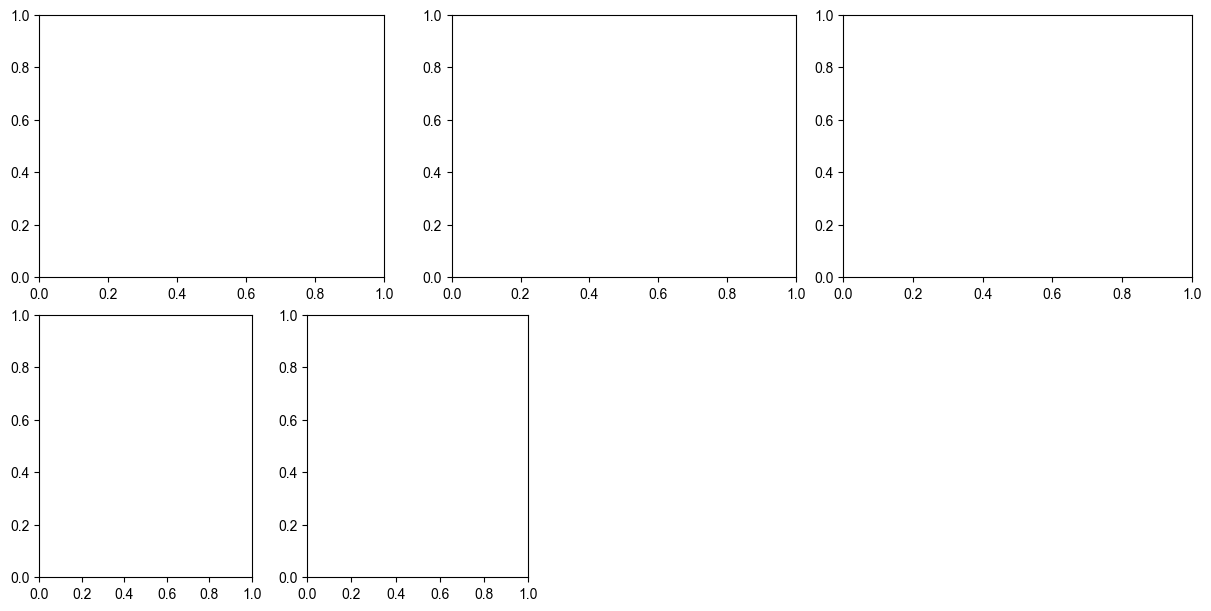

In [54]:


#fig, axes = plt.subplots(3, 3, figsize=(6, 12), sharey=True, gridspec_kw={"hspace": 0.3, "wspace": 0.15}, sharex=False)
fig, axes = plt.subplot_mosaic(
    """
    AAABBBCCC
    DDEE.....
    """,
    figsize=(12, 6),
    layout="constrained",
)
axes = [axes["A"], axes["B"], axes["C"], axes["D"], axes["E"]]

modalities = ["Intersubject", "Vision", "Language"]
clusters = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
xlim = (0, 1.3)

hue_order = ['Scene-dominated', 'Elements-in-scene', 'Element-dominated', 'Animated (Human)', 'Animated (Animal)', 'Inanimate']
hue_palette =  [ *palettes["scene_dominated2"], *palettes["biology"]]
include_all = False
if include_all:
    hue_order = ["All scenes"] + hue_order
    hue_palette = ["C0"] + hue_palette

for j, modality in enumerate(modalities):
    for i, cluster in enumerate(clusters):
        ax = axes[i]
            
        df_subset_g = df_subsets_clusters_g.query("modality == 'Intersubject' and cluster == 'Dorsal Hub' and partition in @partitions_selected").copy()

        df_subset_g = df_subsets_clusters_g.query("modality == @modality and cluster == @cluster and partition in @partitions_selected").copy()
        cka_all = df_subset_g.query("partition_value == 'All scenes'").cka.values[0]
        df_subset_g["cka_percentage"] = df_subset_g["cka"] / cka_all
        df_subset_g

        




        ax.set_title(f"{modality}")
        if j == 1:
            ax.set_title(f"{cluster}\n{modality}")

        sns.barplot(data=df_subset_g, y="partition_value", 
                    x="cka_percentage", hue="partition_value", 
                    hue_order=hue_order, order=hue_order, 
                    palette=hue_palette, ax=ax,  dodge=False,
                    lw=0.5, edgecolor="black",
                    #width=0.4
                    )
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, 0))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))

        if j == 0:
            #ax.set_ylabel(cluster, fontsize=12)
            ax.set_ylabel("")
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel(r"% of Alignment")
        else:
            ax.set_xlabel("")
        
        
        ax.set_xlim(xlim)
        # Set xticklabels fontsize
        # Alignments in center
        ax.tick_params(axis='x', labelsize=7)

        ylim = ax.get_ylim()
        ax.set_ylim(ylim)
        
        for p in range(1, 5+1):
            ax.axvline(p/4, color=(0.24, 0.24, 0.24) if p!=4 else "maroon", linestyle="--", lw=0.5, zorder=-100)

        sns.despine(ax=ax)


#
#fig.savefig(output / "figure_dimensions_barplots_residuals.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
df_subsets_clusters_2 = df_subsets_clusters.copy()
df_subsets_clusters_2 = df_subsets_clusters_2.merge(df_subsets_clusters.query("partition=='All scenes'")[["cka", "modality", "cluster", "subject"]].rename(columns={"cka": "cka_all"}),
                            on=["modality", "cluster", "subject"], how="inner")
df_subsets_clusters_2["percentage_alignment"] = df_subsets_clusters_2["cka"] / df_subsets_clusters_2["cka_all"]
df_subsets_clusters_2 = df_subsets_clusters_2.query("partition in @partitions_selected and partition_value!='All scenes'")


modalities = ["Intersubject", "Vision", "Language"]
clusters_order = ['Visual Cortex', 'Ventral Hub', 'Dorsal Hub']
parititons_order = ['Scene dominated', 'Biology']
hue_order = ['Scene-dominated', 'Elements-in-scene', 'Element-dominated',
             'Animated (Human)', 'Animated (Animal)', 'Inanimate']

hue_order = {
    "Scene dominated": ['Scene-dominated', 'Elements-in-scene', 'Element-dominated'],
    "Biology": ['Animated (Human)', 'Animated (Animal)', 'Inanimate'],
}
palette = {
    "Scene dominated": palettes["scene_dominated2"],
    "Biology": palettes["biology"],
}

fig, axes = plt.subplots(3, 2, figsize=(9, 12), gridspec_kw={"hspace": 0.15, "wspace": 0.05})
for i, modality in enumerate(modalities):
    for j, partition in enumerate(parititons_order):
        ax = axes[i, j]
        # Ax plot hline at 1.0 dahsed maroon
        
        sns.boxplot(
            data=df_subsets_clusters_2.query("modality==@modality and partition==@partition"),
            x="cluster",
            y="percentage_alignment",
            hue="partition_value",
            order=clusters_order,
            palette=palette[partition],
            ax=ax,
            hue_order=hue_order[partition],
            legend=i==0,
            width=0.55,
        )
        #ax.yaxis.set_major_formatter(ticker.PercentFormatter(1, 0))

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_ylim(0.1, 1.6)
        # Plot an vline at 1.0
        ax.set_xlim(-0.5, 2.5)
        ax.hlines(1.0, -0.5, 2.5, color="maroon", linestyle="--", lw=0.6, zorder=-100)
        #ax.axvline(0.5, color=(0.24, 0.24, 0.24), linestyle="--", lw=0.5, zorder=-100)
        #ax.axvline(1.5, color=(0.24, 0.24, 0.24), linestyle="--", lw=0.5, zorder=-100)
        if j == 1:
            sns.despine(ax=ax, left=True)
            ax.set_yticks([])
        else:
            sns.despine(ax=ax)
        # Remove title from legend
        if i == 0:
            loc = "upper left" if j == 0 else "upper right"
            ax.legend(title="", loc=loc)#, bbox_to_anchor=(0.55, 0.99))
        ax.set_title(f"")
        

ylabel = "Proportion of Alignment"
for i in range(3):
    axes[i, 0].set_ylabel(ylabel)

s = 0.02
fig.text(0.5, 0.895-s, "Intersubject", ha='center', fontsize='large')
fig.text(0.5, 0.625-s, "Vision", ha='center', fontsize='large')
fig.text(0.5, 0.355-s, "Language", ha='center', fontsize='large')

fig.savefig(output / "figure_dimensions_boxplots_residuals_2.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:

df_radar_all = df_subsets_clusters_g.query("partition_value == 'All Scenes'").copy()
#df_radar_all
df_radar_all = df_radar_all.drop(columns=["partition", "partition_value"])
df_radar_all = df_radar_all.rename(columns={"cka": "cka_all"})
df_subsets_clusters_g_radar = df_subsets_clusters_g.merge(
    df_radar_all, on=["modality", "cluster"], how="inner"
)
df_subsets_clusters_g_radar["cka_percentage"] = df_subsets_clusters_g_radar["cka"] / df_subsets_clusters_g_radar["cka_all"]
df_subsets_clusters_g_radar = df_subsets_clusters_g_radar.query("partition_value!='All Scenes'")
df_subsets_clusters_g_radar = df_subsets_clusters_g_radar.query("partition in @partitions_selected")

In [ ]:
def plot_radar(df, order, ax, hue_order, order_names=None, palette=None, hue_zorder=None, hue="modality", x="partition_value", y="cka_percentage", ylim=(0, 1.25),
               yticks=[0.25, 0.5, 0.75, 1.25],
               ytickslabels=[0.25, 0.5, 0.75, 1, 1.25],
               ):
    pi = np.pi
    angles = [n / float(len(order)) * 2 * pi for n in range(len(order))]
    
    angles += angles[:1]
    
    # If you want the first axis to be on top:
    offset = pi / 2 - pi/len(order)
    ax.set_theta_offset(offset)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable + add labels
    ax.set_xticks(angles[:-1], order)
    
    ax.set_yticks(yticks)

    # Plot the 1.0 ytick circle red
    circle_angles = np.linspace(0, 2 * np.pi, 100)
    ax.plot(circle_angles, [1.0] * len(circle_angles), color="maroon", linestyle="--", lw=0.8, zorder=-100)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    #ax.set_yticks([10,20,30], ["10","20","30"], color="grey", size=7)
    ax.set_ylim(ylim)
    # Set xticks the name of order left halignment for first 3 orders and right for the rest
    #
    # Remove the angles
    ax.set_yticklabels([])

    if order_names is None:
        order_names = order
    ax.set_xticklabels([])

    # Plot yticks as texts in line with angle
    #alpha = offset - 3*pi/len(order)
    alpha = offset - 6*pi/len(order)
    for tick in ytickslabels:
        #ax.text(alpha, tick, f"{tick:.2f}", ha="center", va="bottom", fontsize=7, rotation=0)
        c=None #if tick != 1 else "maroon"
        ax.text(alpha, tick-0.03, f"{tick:.2f}", ha="left", va="center", fontsize=7, rotation=90, color=c)

    # Plot xticklabels manually to avoid overlapping
    m = 1.25
    for i, label in enumerate(order_names):
        angle = angles[i]
        if i < 3:
            ax.text(angle, ylim[1]*m, label, ha="center", va="center")
        else:
            ax.text(angle, ylim[1]*m, label, ha="center", va="center") 
    
    for i, name in enumerate(hue_order):
        group = df.query(f"{hue} == @name")
        if palette is not None:
            color = palette[i]
        else:
            color = None

        if hue_zorder is not None:
            zorder = hue_zorder[i]
        else:
            zorder = 10

        # Sort by x order
        group = group.sort_values(x, key=lambda x: x.map({v: i for i, v in enumerate (order)}))
        values = group[y].values.flatten().tolist()
        values += values[:1]
        #values = np.clip(values, 0, 1.23)
        ax.plot(angles, values, linewidth=1.5, label=name, zorder=zorder, color=color)
        ax.fill(angles, values, alpha=0.15, zorder=zorder, color=color)
    
    return ax




fig, axes = plt.subplots(3, 1, figsize=(4, 12), subplot_kw=dict(polar=True))
cluster = "Ventral Hub"
order = ["Scene-dominated", "Elements-in-scene", "Element-dominated",
         "Inanimate", "Animated (Animal)", "Animated (Human)"]
order_names = ["Scene\nDominated", "Elements\nin-Scene", " Element\nDominated", 
              "Inanimate", "Animated\n(Animal)",  "Animated\n(Human)", ]
hue_order = ["Intersubject", "Vision", "Language"]
modality_palette = ["C0", "C1", "C2"]
hue_zorders = [
    [11, 10, 12],
    [10, 11, 12],
    [10, 11, 12]
]
palette = ["#D36060","#46657F", "#60A57C"]

for i, cluster in enumerate(clusters_order):
    ax = axes[i]
    df_radar_cluster = df_subsets_clusters_g_radar.query("cluster==@cluster and partition_value in @order")
    ax = plot_radar(df_radar_cluster,  hue_order=hue_order, order=order, 
                    order_names=order_names, ax=ax, hue_zorder=hue_zorders[i],
                    palette=palette,
                    ylim=(0, 1.25))
    ax.set_title(cluster, fontsize="x-large")

#axes[0].legend(title="", loc="upper right", bbox_to_anchor=(0, 0.9))

# Save the legend in another fig
fig_legend = plt.figure(figsize=(1, 1))
ax = fig_legend.add_subplot()
# Create a legend
handles = [plt.Line2D([0], [0], color=palette[i], lw=2) for i in range(3)]
labels = ["Intersubject", "Vision", "Language"]
ax.legend(handles, labels, title="", loc="center")
ax.axis("off")


# Save as svg
#fig.savefig(output / "figure_dimensions_radar.pdf", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(output / "figure_dimensions_radar.svg", bbox_inches="tight", dpi=300, transparent=True)

# Save the legend as pdf
#fig_legend.savefig(output / "figure_dimensions_radar_legend.pdf", bbox_inches="tight", dpi=300, transparent=True)



In [ ]:
fig_legend = plt.figure(figsize=(1, 1))
ax = fig_legend.add_subplot()
# Create a legend
handles = [plt.Line2D([0], [0], color=palette[i], lw=2) for i in range(3)]
labels = ["Intersubject", "Vision", "Language"]
ax.legend(handles, labels, title="", loc="center", ncol=3)
ax.axis("off")
fig_legend.savefig(output / "figure_dimensions_radar_legend2.pdf", bbox_inches="tight", dpi=300, transparent=True)


In [ ]:
fig, ax = plt.subplots(figsize=(4, 0.3))
ax.set_xlim(0, 1.25)
ax.set_yticks([])
# Invert x axis
#ax.invert_xaxis()
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0, 1.25])
ax.set_xlabel(r"Proportion of Alignment (${CKA}_{\text{Subset}}\, / \,{CKA_{\text{All}}}$)")
sns.despine(ax=ax, left=True)
fig.savefig(output / "figure_dimensions_radar_scale.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 0.3))
ax.set_xlim(0, 2.5)
ax.set_yticks([])
# Invert x axis
#ax.invert_xaxis()
ax.set_xticks(np.linspace(0, 2.5, 6))
#ax.set_xticks([])
# Set minor ticks
ax.set_xticks([0.25, 0.75, 1.25, 1.75, 2.25], minor=True)
#ax.set_xticklabels(["", "", "0", "", ""], minor=True)
#ax.set_xticklabels([1.25, 1.0, 0.25, 0.25, 0.75, 1.25])
#ax.set_xticklabels([1.25, "", "", "", "", 1.25])
ax.set_xticklabels(["", "", "", "", "", ""])

ax.set_xlabel(r"Proportion of Alignment (${CKA}_{\text{Subset}}\, / \,{CKA_{\text{All}}}$)")
sns.despine(ax=ax, left=True)
fig.savefig(output / "figure_dimensions_radar_scale2.pdf", bbox_inches="tight", dpi=300, transparent=True)

In [ ]:
deep_palette = sns.color_palette("deep")
list(deep_palette) #

## RSA Version

In [ ]:
filename_intersubject_rsa = Path("data/data_rsa/nsd_alignment_intersubject_partitions_rsa.parquet")
df_intersubject_rsa = pd.read_parquet(filename_intersubject_rsa).rename(columns={"subject_i": "subject", "cka": "rsa"})
df_intersubject_rsa = df_intersubject_rsa.query("rsa < 1 and rsa > -1")
df_intersubject_rsa = df_intersubject_rsa.groupby(["subject", "roi", "partition", "partition_value"]).rsa.mean().reset_index()
df_intersubject_rsa["modality"] = "Intersubject"


filename_models_rsa = Path("data/data_rsa/nsd_alignment_models_partitions_rsa.parquet")
df_models_rsa = pd.read_parquet(filename_models_rsa).rename(columns={"cka": "rsa"}).query("rsa < 1 and rsa > -1")

df_models_rsa = df_models_rsa.groupby(["model", "partition", "partition_value", "subject", "roi"]).rsa.max().reset_index()
df_models_rsa["modality"] = df_models_rsa.model.apply(lambda x: "Language" if x.endswith("coco") else "Vision")
df_models_rsa = df_models_rsa.groupby(["modality", "subject", "partition", "partition_value", "roi"]).rsa.mean().reset_index()
df_rsa = pd.concat([df_intersubject_rsa, df_models_rsa], ignore_index=True)
df_rsa = df_rsa.groupby(["modality", "roi", "partition", "partition_value"]).rsa.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)
df_rsa = df_rsa.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], on="roi", how="inner")
df_rsa["cluster"] = df_rsa["name"].map(cluster_rois).fillna("Other")
df_rsa.partition_value = df_rsa.partition_value.str.capitalize()
df_rsa.partition_value = df_rsa.partition_value.str.replace("human", "Human")
df_rsa.partition_value = df_rsa.partition_value.str.replace("animal", "Animal")
df_rsa.partition = df_rsa.partition.str.replace("_", " ").str.capitalize()
df_rsa.partition_value = df_rsa.partition_value.replace({"All": "All Scenes"})
df_rsa_clusters = df_rsa.query("cluster!='Other'")
df_rsa_clusters = df_rsa_clusters.groupby(["modality",  "cluster",  "partition", "partition_value"]).rsa.mean().reset_index()
df_rsa_clusters_all = df_rsa_clusters.query("partition_value == 'All Scenes'").copy().rename(columns={"rsa": "rsa_all"})
df_rsa_clusters_all = df_rsa_clusters_all.drop(columns=["partition", "partition_value"])
df_rsa_clusters = df_rsa_clusters.merge(df_rsa_clusters_all, on=["modality", "cluster"], how="inner")
df_rsa_clusters["rsa_percentage"] = df_rsa_clusters["rsa"] / df_rsa_clusters["rsa_all"]
df_rsa_clusters = df_rsa_clusters.query("partition_value!='All Scenes'")
df_rsa_clusters = df_rsa_clusters.query("partition in @partitions_selected")
df_rsa_clusters

In [ ]:

fig, axes = plt.subplots(3, 1, figsize=(4, 12), subplot_kw=dict(polar=True))
cluster = "Ventral Hub"
order = ["Scene-dominated", "Elements-in-scene", "Element-dominated",
         "Inanimate", "Animated (Animal)", "Animated (Human)"]
order_names = ["Scene\nDominated", "Elements\nin-Scene", " Element\nDominated", 
              "Inanimate", "Animated\n(Animal)",  "Animated\n(Human)", ]
hue_order = ["Intersubject", "Vision", "Language"]
modality_palette = ["C0", "C1", "C2"]
hue_zorders = [
    [11, 10, 12],
    [10, 11, 12],
    [10, 11, 12]
]
palette = ["#D36060","#46657F", "#60A57C"]

for i, cluster in enumerate(clusters_order):
    ax = axes[i]
    df_radar_cluster = df_rsa_clusters.query("cluster==@cluster and partition_value in @order")
    ax = plot_radar(df_radar_cluster,  hue_order=hue_order, order=order, 
                    order_names=order_names, ax=ax, hue_zorder=hue_zorders[i],
                    palette=palette,
                    y="rsa_percentage",
                    ylim=(0, 2))
    ax.set_title(cluster, fontsize="x-large")

#axes[0].legend(title="", loc="upper right", bbox_to_anchor=(0, 0.9))

# Save the legend in another fig
fig_legend = plt.figure(figsize=(1, 1))
ax = fig_legend.add_subplot()
# Create a legend
handles = [plt.Line2D([0], [0], color=palette[i], lw=2) for i in range(3)]
labels = ["Intersubject", "Vision", "Language"]
ax.legend(handles, labels, title="", loc="center")
ax.axis("off")


# Save as svg
#fig.savefig(output / "figure_dimensions_radar.pdf", bbox_inches="tight", dpi=300, transparent=True)
#fig.savefig(output / "figure_dimensions_radar.svg", bbox_inches="tight", dpi=300, transparent=True)

# Save the legend as pdf
#fig_legend.savefig(output / "figure_dimensions_radar_legend.pdf", bbox_inches="tight", dpi=300, transparent=True)



In [ ]:
filename_intersubject_rsa = Path("data/data_rsa/nsd_alignment_intersubject_partitions_rsa.parquet")
df_intersubject_rsa = pd.read_parquet(filename_intersubject_rsa).rename(columns={"subject_i": "subject", "cka": "rsa"})
df_intersubject_rsa = df_intersubject_rsa.query("rsa < 1 and rsa > -1")
df_intersubject_rsa = df_intersubject_rsa.groupby(["subject", "roi", "partition", "partition_value"]).rsa.mean().reset_index()
df_intersubject_rsa["modality"] = "Intersubject"


filename_models_rsa = Path("data/data_rsa/nsd_alignment_models_partitions_rsa.parquet")
df_models_rsa = pd.read_parquet(filename_models_rsa).rename(columns={"cka": "rsa"}).query("rsa < 1 and rsa > -1")

df_models_rsa = df_models_rsa.groupby(["model", "partition", "partition_value", "subject", "roi"]).rsa.max().reset_index()
df_models_rsa["modality"] = df_models_rsa.model.apply(lambda x: "Language" if x.endswith("coco") else "Vision")
df_models_rsa = df_models_rsa.groupby(["modality", "subject", "partition", "partition_value", "roi"]).rsa.mean().reset_index()
df_rsa = pd.concat([df_intersubject_rsa, df_models_rsa], ignore_index=True)
df_rsa
# df_rsa = df_rsa.groupby(["modality", "roi", "partition", "partition_value"]).rsa.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)
df_rsa = df_rsa.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], on="roi", how="inner")
df_rsa["cluster"] = df_rsa["name"].map(cluster_rois).fillna("Other")
df_rsa.partition_value = df_rsa.partition_value.str.capitalize()
df_rsa.partition_value = df_rsa.partition_value.str.replace("human", "Human")
df_rsa.partition_value = df_rsa.partition_value.str.replace("animal", "Animal")
df_rsa.partition = df_rsa.partition.str.replace("_", " ").str.capitalize()
df_rsa.partition_value = df_rsa.partition_value.replace({"All": "All Scenes"})
df_rsa_clusters = df_rsa.query("cluster!='Other'")
df_rsa_clusters = df_rsa_clusters.groupby(["modality",  "cluster",  "subject", "partition", "partition_value"]).rsa.mean().reset_index()
df_rsa_clusters
df_rsa_clusters_all = df_rsa_clusters.query("partition_value == 'All Scenes'").copy().rename(columns={"rsa": "rsa_all"})
df_rsa_clusters_all = df_rsa_clusters_all.drop(columns=["partition", "partition_value"])
# df_rsa_clusters = df_rsa_clusters.merge(df_rsa_clusters_all, on=["modality", "cluster"], how="inner")
# df_rsa_clusters["rsa_percentage"] = df_rsa_clusters["rsa"] / df_rsa_clusters["rsa_all"]
#df_rsa_clusters = df_rsa_clusters.query("partition_value!='All Scenes'")
df_rsa_clusters = df_rsa_clusters.query("partition in @partitions_selected")
df_rsa_clusters

In [ ]:
partition_values

In [ ]:
# Make a facegrid plot with data=df_rsa_clusters, x="cluster" y="rsa" rows="modality", hue="partition_value",
# Set colr order : ["Intersubject", "Vision", "Language"]
col_order = ["Intersubject", "Vision", "Language"]

g = sns.FacetGrid(df_rsa_clusters, col="modality", row="cluster", hue="partition_value", margin_titles=True, col_order=col_order, row_order=clusters_order)
g.map_dataframe(sns.boxplot, x="partition_value", y="rsa")
# Add legend
# Set ylim (0, 0.3)

g.axes[0, 0].set_ylim(0, 0.3)

g.add_legend(title="", loc="upper right", bbox_to_anchor=(1, 1))


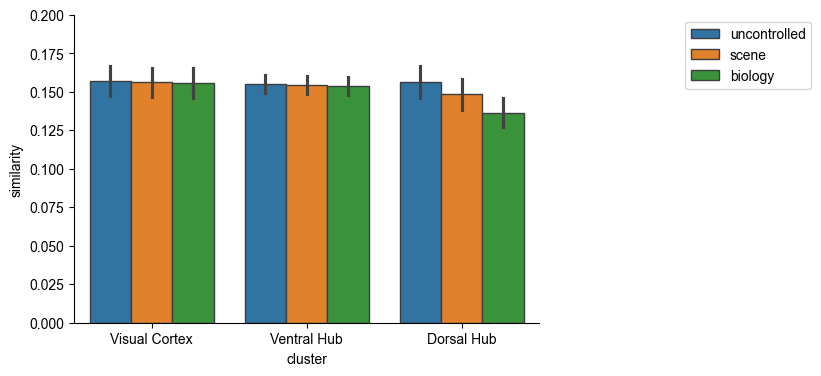

In [104]:
controls = [ "uncontrolled", "scene", "biology",]
df_controled = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_controled_joined_1.parquet").query("control in ['scene', 'biology', 'uncontrolled']")
df_controled = df_controled.query("roi_x == roi_y and subject_i!=subject_j").groupby(["roi_x", "control", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled = df_controled.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], left_on="roi_x", right_on="roi", how="inner")
df_controled = df_controled.drop(columns=["roi_x"])
df_controled["cluster"] = df_controled["name"].map(cluster_rois).fillna("Other")
df_controled_glusters = df_controled.query("cluster!='Other'").groupby(["control", "cluster", "subject_i"], observed=True).similarity.mean().reset_index()
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=df_controled_glusters, x="cluster", y="similarity", hue="control", ax=ax, hue_order=controls, order=clusters_order, edgecolor=(0.24, 0.24, 0.24),  dodge=True, errorbar="se")
# Set legend outside
ax.legend(title="", loc="upper right", bbox_to_anchor=(1.6, 1))
ax.set_ylim(0, 0.2)
sns.despine(ax=ax)

In [160]:
df_model_controled = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_controled_joined.parquet")
df_model_controled = df_model_controled.groupby(["model", "roi", "subject", "control"]).similarity.max().reset_index()
models_info = pd.read_csv("data/models-info.csv")
df_model_controled = df_model_controled.merge(models_info[["model_name", "modality"]], left_on="model", right_on="model_name", how="inner")
df_model_controled = df_model_controled.groupby(["roi", "modality", "control", "subject"]).similarity.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)[["roi", "name", "mne_name", "area", "area_id"]]
df_model_controled = df_model_controled.merge(df_hcp, on="roi", how="inner")
df_model_controled["cluster"] = df_model_controled["name"].map(cluster_rois).fillna("Other")
df_model_controled_clusters = df_model_controled.query("cluster!='Other'").groupby(["modality", "cluster", "control", "subject"], observed=True).similarity.mean().reset_index()
df_model_controled_clusters

df_controled = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_controled_joined_1.parquet")#.query("control in ['scene', 'biology', 'uncontrolled']")
df_controled = df_controled.query("roi_x == roi_y and subject_i==subject_j").groupby(["roi_x", "control", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled = df_controled.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], left_on="roi_x", right_on="roi", how="inner")
df_controled = df_controled.drop(columns=["roi_x"])
df_controled["cluster"] = df_controled["name"].map(cluster_rois).fillna("Other")
df_controled_glusters = df_controled.query("cluster!='Other'").groupby(["control", "cluster", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled_glusters = df_controled_glusters.rename(columns={"subject_i": "subject"})
df_controled_glusters["modality"] = "intersubject"


df_controled_clusters = pd.concat([df_controled_glusters, df_model_controled_clusters], ignore_index=True)
df_controled_clusters.modality = df_controled_clusters.modality.str.capitalize()
df_controled_clusters


,control,cluster,subject,similarity,modality
0,biology,Dorsal Hub,1,0.209736,Intersubject
1,biology,Dorsal Hub,2,0.263255,Intersubject
2,biology,Dorsal Hub,3,0.195221,Intersubject
3,biology,Dorsal Hub,4,0.204787,Intersubject
4,biology,Dorsal Hub,5,0.322893,Intersubject
...,...,...,...,...,...
931,visual_cortex_cca_2,Visual Cortex,4,0.097776,Vision
932,visual_cortex_cca_2,Visual Cortex,5,0.103177,Vision
933,visual_cortex_cca_2,Visual Cortex,6,0.095217,Vision
934,visual_cortex_cca_2,Visual Cortex,7,0.076346,Vision


In [164]:
list(df_controled_clusters.control.unique())

['biology',
 'biology_binary',
 'dorsal_hub_cca_1',
 'dorsal_hub_cca_1-3',
 'dorsal_hub_cca_2',
 'scene',
 'uncontrolled',
 'ventral_hub_cca_1',
 'ventral_hub_cca_1-3',
 'ventral_hub_cca_2',
 'visual_cortex_cca_1',
 'visual_cortex_cca_1-3',
 'visual_cortex_cca_2']

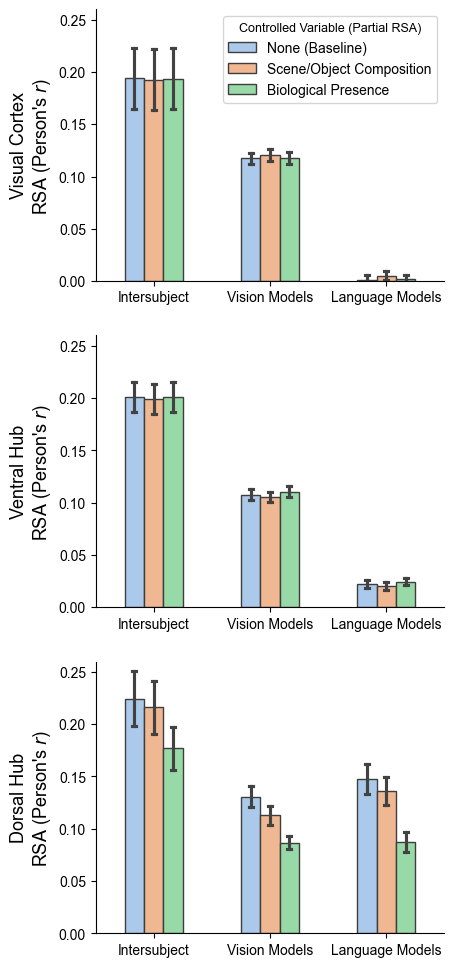

In [266]:
# Make a barplot with: data=df_controled_clusters, x="modality" row="cluster" y="similarity", hue="control"
row_order = ["Intersubject", "Vision", "Language"]
cluster_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
controls = ["uncontrolled", "scene", "biology_binary"]#,"visual_cortex_cca_1", "ventral_hub_cca_1", "dorsal_hub_cca_1"]

# Rename controls:
control_names = {
    "uncontrolled": "None (Baseline)",
    "scene": "Scene/Object Composition",
    "biology_binary": "Biological Presence",
}
modality_names = {
    "Intersubject": "Intersubject",
    "Vision": "Vision Models",
    "Language": "Language Models",
}
fig, axes = plt.subplots(3, 1, figsize=(4.5, 12), sharey=True, gridspec_kw={"hspace": 0.2}, sharex=False)
for i, cluster in enumerate(cluster_order):
    ax = axes[i]
    df_controled_cluster = df_controled_clusters.query("cluster==@cluster").copy()
    df_controled_cluster["control"] = df_controled_cluster["control"].replace(control_names)
    df_controled_cluster["modality"] = df_controled_cluster["modality"].replace(modality_names)
    
    sns.barplot(data=df_controled_cluster, x="modality", y="similarity", hue="control", ax=ax, hue_order=control_names.values(), order=modality_names.values(), edgecolor=(0.24, 0.24, 0.24), dodge=True, errorbar="se", width=0.5, legend=i==0,
                palette="pastel", capsize=0.1, lw=1)
    
    
    #ax.set_title(cluster)
    
    ax.set_ylabel(f"{cluster}\nRSA (Person's $r$)", fontsize=13)
    ax.set_xlabel("")
    if i == 0:
        ax.legend(title="Controlled Variable (Partial RSA)", title_fontsize=9)
    ax.set_ylim(0, 0.26)
    
    sns.despine(ax=ax)

    fig.savefig(output / "figure_dimensions_barplots_controled.pdf", bbox_inches="tight", dpi=300, transparent=True)



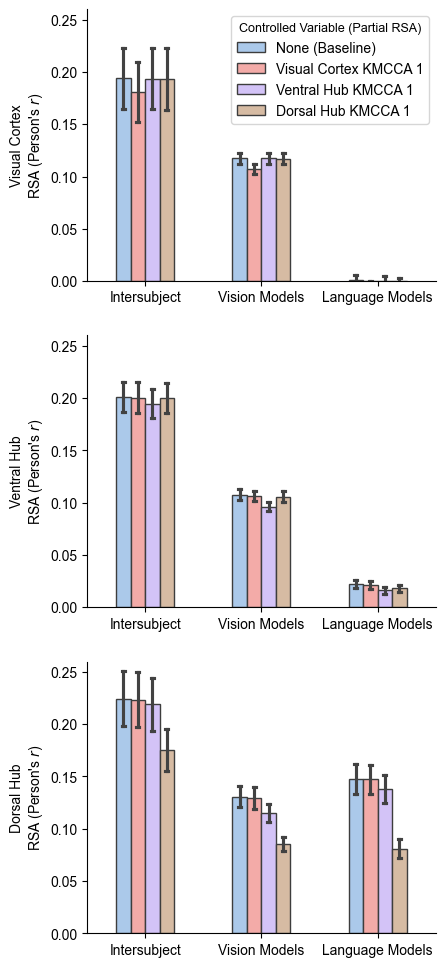

In [264]:
# Make a barplot with: data=df_controled_clusters, x="modality" row="cluster" y="similarity", hue="control"
row_order = ["Intersubject", "Vision", "Language"]
cluster_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
controls = ["visual_cortex_cca_1", "ventral_hub_cca_1", "dorsal_hub_cca_1"]

# Rename controls:
control_names = {
    "uncontrolled": "None (Baseline)",
    "visual_cortex_cca_1": "Visual Cortex KMCCA 1",
    "ventral_hub_cca_1": "Ventral Hub KMCCA 1",
    "dorsal_hub_cca_1": "Dorsal Hub KMCCA 1",
}
modality_names = {
    "Intersubject": "Intersubject",
    "Vision": "Vision Models",
    "Language": "Language Models",
}
fig, axes = plt.subplots(3, 1, figsize=(4.5, 12), sharey=True, gridspec_kw={"hspace": 0.2}, sharex=False)

# Get pasetl palette C0, C3, C4, C5 to avoid overlapping with the previous plot
palette = sns.color_palette("pastel")
palette = [palette[0], palette[3], palette[4], palette[5]]
for i, cluster in enumerate(cluster_order):
    ax = axes[i]
    df_controled_cluster = df_controled_clusters.query("cluster==@cluster").copy()
    df_controled_cluster["control"] = df_controled_cluster["control"].replace(control_names)
    df_controled_cluster["modality"] = df_controled_cluster["modality"].replace(modality_names)


    
    sns.barplot(data=df_controled_cluster, x="modality", y="similarity", hue="control", ax=ax, hue_order=control_names.values(), order=modality_names.values(), edgecolor=(0.24, 0.24, 0.24), dodge=True, errorbar="se", width=0.5, legend=i==0,
                palette=palette, capsize=0.1, lw=1)
    
    
    #ax.set_title(cluster)
    
    ax.set_ylabel(f"{cluster}\nRSA (Person's $r$)")
    ax.set_xlabel("")
    if i == 0:
        ax.legend(title="Controlled Variable (Partial RSA)", title_fontsize=9)
    ax.set_ylim(0, 0.26)
    
    sns.despine(ax=ax)

    fig.savefig(output / "figure_dimensions_barplots_controled_kmcca.pdf", bbox_inches="tight", dpi=300, transparent=True)



In [245]:
baseline = df_controled_clusters.query("control in @controls and control== 'uncontrolled'").copy()
comparisons = df_controled_clusters.query("control in @controls and control!= 'uncontrolled'").copy()
comparisons = comparisons.merge(baseline[["modality", "cluster", "similarity", "subject"]], on=["modality", "cluster", "subject"], how="inner", suffixes=("_comparison", "_baseline"))# Make 
from scipy import stats

# Group by modality, cluster and make a t-test using scipy.stats.ttest_rel
comparisons = comparisons.groupby(["modality", "cluster", "control"]).apply(lambda x: stats.ttest_rel(x["similarity_comparison"], x["similarity_baseline"])[1], include_groups=False).reset_index()

comparisons = comparisons.rename(columns={0: "p_value"})

# Apply correction for multiple comparisons using bonferroni
from statsmodels.stats.multitest import multipletests
# Apply bonferroni correction
comparisons["p_value_corrected"] = multipletests(comparisons["p_value"], method="bonferroni")[1]
comparisons["significant"] = comparisons["p_value_corrected"] < 0.05

comparisons.sort_values(["cluster", "control", "modality"])


,modality,cluster,control,p_value,p_value_corrected,significant
0,Intersubject,Dorsal Hub,biology_binary,0.000179,0.003218,True
6,Language,Dorsal Hub,biology_binary,0.000006,0.000114,True
12,Vision,Dorsal Hub,biology_binary,0.000013,0.000234,True
1,Intersubject,Dorsal Hub,scene,0.000064,0.001153,True
7,Language,Dorsal Hub,scene,0.000005,0.000089,True
13,Vision,Dorsal Hub,scene,0.000009,0.000168,True
2,Intersubject,Ventral Hub,biology_binary,0.002860,0.051479,False
8,Language,Ventral Hub,biology_binary,0.000180,0.003241,True
14,Vision,Ventral Hub,biology_binary,0.000046,0.000822,True
3,Intersubject,Ventral Hub,scene,0.002081,0.037460,True


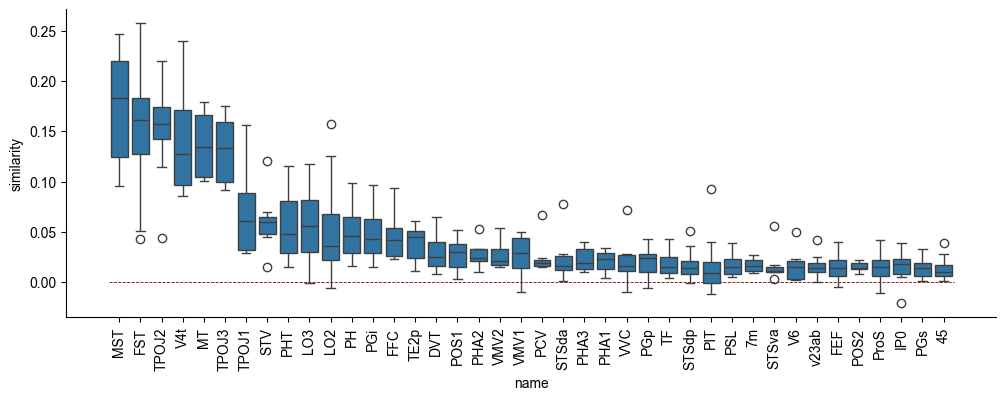

In [298]:
top=40
order = df_model_controled.query("modality == 'language' and control=='uncontrolled'").groupby(["modality", "roi", "name"]).similarity.mean().reset_index().sort_values(["similarity"], ascending=False).head(top).name.tolist()
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=df_model_controled.query("modality == 'language' and name in @order and control=='uncontrolled'"), x="name", y="similarity", order=order, ax=ax)
sns.despine(ax=ax)
ax.hlines(0.0, -0.5, top-0.5, color="maroon", linestyle="--", lw=0.6, zorder=-100)
plt.xticks(rotation=90);

,cluster,modality,p_value,t_statistic,p_value_corrected,apa_significance
0,Dorsal Hub,Intersubject,1.945775e-04,7.094639,0.001557,**
1,Dorsal Hub,Language,7.393940e-06,11.732952,0.000059,***
2,Dorsal Hub,Vision,1.616186e-05,10.433558,0.000129,***
3,Ventral Hub,Intersubject,1.886327e-04,7.129996,0.001509,**
4,Ventral Hub,Language,1.177726e-04,7.684186,0.000942,***
5,Ventral Hub,Vision,4.793076e-05,8.839940,0.000383,***
6,Visual Cortex,Intersubject,4.180068e-05,9.028098,0.000334,***
8,Visual Cortex,Vision,1.546031e-07,20.692172,0.000001,***


Text(0, 0.5, '')

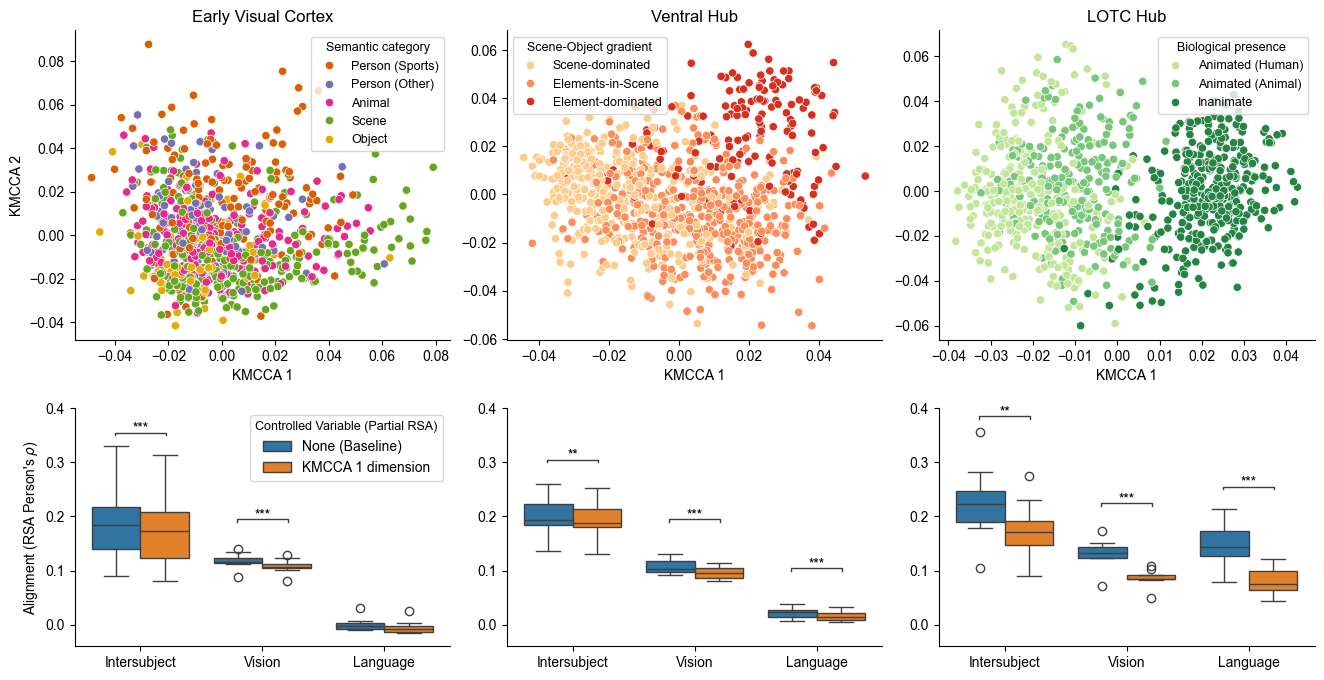

In [7]:
df = pd.read_parquet(filename_projections)
df["biology"] = "Inanimate"
df.loc[df["image_category"].isin(["animal"]), "biology"] = "Animated (Animal)"
df.loc[df["image_category"].isin(["person_action", "sports"]) & df.life, "biology"] = "Animated (Human)"
biology_palette = {
    "Animated (Human)": "C0",
    "Animated (Animal)": "C1",
    "Inanimate": "C2",
}


hue = ["category2", "scene_dominated2", "biology"]
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

df["scene_dominated2"] = df["scene_dominated"]
df.loc[df["category2"] == "object", "scene_dominated2"] = "object-dominated"
df.loc[df.nsd_id.isin(object_dominated), "scene_dominated2"] = "object-dominated"
df.scene_dominated2 = df.scene_dominated2.str.capitalize()
#df.loc[df["category2"] == "scene", "scene_dominated2"] = "scene-dominated"

scene_mapping = {
    "Scene-dominated": "Scene-dominated",
    "Object-in-scene": "Elements-in-Scene",
    "Object-dominated": "Element-dominated",
}
df.scene_dominated2 = df.scene_dominated2.map(scene_mapping)

scene_palette = {
    "Scene-dominated": "C0",
    "Elements-in-Scene": "C1",
    "Element-dominated": "C2",
}

category2_mapping = {
    "sports": "Person (Sports)",
    "person_action": "Person (Other)",
    "animal": "Animal",
    "scene": "Scene",
    "object": "Object",
}
df.category2 = df.category2.map(category2_mapping)
# colorbrewer:accent_5
palettes = {"category2": list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1])),
            "scene_dominated2": list(Colormap('colorbrewer:orrd_4')([0.33, 0.66, 1])),
            "biology":  list(Colormap('colorbrewer:ylgn_4')([0.33, 0.66, 1]))}
hue_order = {"biology": list(biology_palette.keys()),
             "scene_dominated2": list(scene_palette.keys()),
                "category2": list(category2_mapping.values())}


fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=False, sharex=False, gridspec_kw={"hspace": 0.25, "wspace": 0.15, "height_ratios": [1.3, 1]})


    
ax1 = axes[0, 0]
df_plot = df.query("roi == 'visual_cortex'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
sns.scatterplot(data=df_plot,x='cca_1', y='cca_2', hue='category2', ax=ax1, palette=palettes["category2"], hue_order=hue_order["category2"])

# Remove legend title

ax1.set_title("Early Visual Cortex", fontsize="large")

ax2 = axes[0, 1]
df_plot = df.query("roi == 'ventral_hub'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
ax2.set_title("Ventral Hub", fontsize="large")

sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue='scene_dominated2', ax=ax2, palette=palettes["scene_dominated2"], hue_order=hue_order["scene_dominated2"])



ax3 = axes[0, 2]
df_plot = df.query("roi == 'dorsal_hub'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue='biology', ax=ax3, palette=palettes["biology"], hue_order=hue_order["biology"])

ax3.set_title("LOTC Hub", fontsize="large")

# for ax in axes.flat[:3]:
#     #ax.set_xticks(np.linspace(0, 1, 5))
#     margin = 0.1
#     #ax.set_xlim(0-margin, 1+margin)
#     #ax.set_yticks(np.linspace(0, 1, 5))
#     #ax.set_ylim(0-margin, 1+margin+0.05)
#     #ax.set_xticklabels([])
#     #ax.set_yticklabels([])
#     ax.set_xlabel("KMCCA 1")
#     ax.set_ylabel("KMCCA 2")



for ax in axes.flat:
    sns.despine(ax=ax)

cluster_rois = {
    'Visual Cortex': ['V1', 'V2', 'V3', 'V4'],
    'Ventral Hub': ['PHA1', "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
}
order = list(cluster_rois.keys())
cluster_rois = {v : k for k, values in cluster_rois.items() for v in values}

df_model_controled = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_controled_joined.parquet")
df_model_controled = df_model_controled.groupby(["model", "roi", "subject", "control"], observed=True).similarity.max().reset_index()
models_info = pd.read_csv("data/models-info.csv")
df_model_controled = df_model_controled.merge(models_info[["model_name", "modality"]], left_on="model", right_on="model_name", how="inner")
df_model_controled = df_model_controled.groupby(["roi", "modality", "control", "subject"], observed=True).similarity.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)[["roi", "name", "mne_name", "area", "area_id"]]
df_model_controled = df_model_controled.merge(df_hcp, on="roi", how="inner")
df_model_controled["cluster"] = df_model_controled["name"].map(cluster_rois).fillna("Other")
df_model_controled_clusters = df_model_controled.query("cluster!='Other'").groupby(["modality", "cluster", "control", "subject"], observed=True).similarity.mean().reset_index()
df_model_controled_clusters

df_controled = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_controled_joined_1.parquet")#.query("control in ['scene', 'biology', 'uncontrolled']")
df_controled = df_controled.query("roi_x == roi_y and subject_i==subject_j").groupby(["roi_x", "control", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled = df_controled.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], left_on="roi_x", right_on="roi", how="inner")
df_controled = df_controled.drop(columns=["roi_x"])
df_controled["cluster"] = df_controled["name"].map(cluster_rois).fillna("Other")
df_controled_glusters = df_controled.query("cluster!='Other'").groupby(["control", "cluster", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled_glusters = df_controled_glusters.rename(columns={"subject_i": "subject"})
df_controled_glusters["modality"] = "intersubject"


df_controled_clusters = pd.concat([df_controled_glusters, df_model_controled_clusters], ignore_index=True)
df_controled_clusters.modality = df_controled_clusters.modality.str.capitalize()

modality_order = ["Intersubject", "Vision", "Language"]
# uncontrolled, dorsal_hub_cca_1, ventral_hub_cca_1, visual_cortex_cca_1
hue_order = ['uncontrolled', 'visual_cortex_cca_1']
df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Visual Cortex'").copy()
df_plot.control = df_plot.control.astype(str)
df_plot_evc = df_plot.copy()
df_plot.control = df_plot.control.replace({"visual_cortex_cca_1": "KMCCA 1 dimension", "uncontrolled": "None (Baseline)"})
hue_order = ['None (Baseline)', 'KMCCA 1 dimension']
ax4 = axes[1, 0]

sns.boxplot(data=df_plot, x='modality', y='similarity', hue='control', ax=ax4, order=modality_order, hue_order=hue_order)


hue_order = ['uncontrolled', 'ventral_hub_cca_1']
df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Ventral Hub'").copy()
df_plot.control = df_plot.control.astype(str)
df_plot_ventral = df_plot.copy()

ax5 = axes[1, 1]
sns.boxplot(data=df_plot, x='modality', y='similarity', hue='control', ax=ax5, order=modality_order, hue_order=hue_order)


hue_order = ['uncontrolled', 'dorsal_hub_cca_1']
df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Dorsal Hub'").copy()
df_plot.control = df_plot.control.astype(str)
df_plot_dorsal = df_plot.copy()
ax6 = axes[1, 2]
sns.boxplot(data=df_plot, x='modality', y='similarity', hue='control', ax=ax6, order=modality_order, hue_order=hue_order)

ax4.set_title("Early Visual Cortex", fontsize="large")
ax5.set_title("Ventral Hub", fontsize="large")
ax6.set_title("LOTC Hub", fontsize="large")
# Remove a5 and a6 legends completely
ax5.legend_.remove()
ax6.legend_.remove()
# Change title of first legend 
ax4.legend(title="Controlled Variable (Partial RSA)", title_fontsize=9, loc="upper right")

for ax in axes.flat[3:]:
    ax.set_xlabel("")
    ax.set_ylim(-0.04, 0.4)
    ax.set_ylabel(r"Alignment (RSA Person's $\rho$)")

ax1.legend(title="Semantic category", loc="upper right",  ncol=1, fontsize=9, title_fontsize=9)
ax2.legend(title="Scene-Object gradient", loc="upper left",  ncol=1, fontsize=9, title_fontsize=9)
ax3.legend(title="Biological presence ", loc="upper right",  ncol=1, fontsize=9, title_fontsize=9)


df_filtered = pd.concat([df_plot_evc, df_plot_ventral, df_plot_dorsal], ignore_index=True)
df_filtered.control = df_filtered.control.replace({"visual_cortex_cca_1": "controlled",
                             "ventral_hub_cca_1": "controlled",
                            "dorsal_hub_cca_1": "controlled",
                            })

df_filtered_controled = df_filtered.query("control == 'controlled'").copy().rename(columns={"similarity": "partial_rsa"}).drop(columns=["control"])
df_filtered_uncontroled = df_filtered.query("control == 'uncontrolled'").copy().rename(columns={"similarity": "rsa"}).drop(columns=["control"])

df_filtered = df_filtered_controled.merge(df_filtered_uncontroled, on=["cluster", "modality", "subject"])
df_filtered


# By each cluster, modality and using subject for a paired t-test
from scipy import stats
comparisons = df_filtered.groupby(["cluster", "modality"]).apply(lambda x: stats.ttest_rel(x["rsa"], x["partial_rsa"]), include_groups=False).reset_index()
comparisons["p_value"] = comparisons[0].apply(lambda x: x.pvalue)
comparisons["t_statistic"] = comparisons[0].apply(lambda x: x.statistic)
comparisons = comparisons.drop(columns=[0])

# Apply 
from statsmodels.stats.multitest import multipletests
# Use family-wise error rate correction method
method = "bonferroni"
comparisons = comparisons.query("modality != 'Language' or cluster != 'Visual Cortex'").copy()
comparisons["p_value_corrected"] = multipletests(comparisons["p_value"], method=method)[1]
comparisons["apa_significance"] = comparisons["p_value_corrected"].apply(lambda x: "ns" if x > 0.05 else ("*" if x < 0.05 and x >= 0.01 else ("**" if x < 0.01 and x >= 0.001 else "***")))

display(comparisons)

#for cluster in ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]:

w = 0.21
h = 0.005
add_pvalue_bracket(ax=ax4, x1=0-w, x2=0+w, y=0.35, height=h, text="***")
add_pvalue_bracket(ax=ax4, x1=1-w, x2=1+w, y=0.19, height=h, text="***") # 0.000001	
# add_pvalue_bracket(ax=ax4, x1=2-w, x2=2+w, y=0.10, height=h, text="***") # 0.000047	

add_pvalue_bracket(ax=ax5, x1=0-w, x2=0+w, y=0.3, height=h, text="**") # 0.001698	
add_pvalue_bracket(ax=ax5, x1=1-w, x2=1+w, y=0.19, height=h, text="***") # 0.000431	
add_pvalue_bracket(ax=ax5, x1=2-w, x2=2+w, y=0.10, height=h, text="***") # 0.001060	

add_pvalue_bracket(ax=ax6, x1=0-w, x2=0+w, y=0.38, height=h, text="**") # 0.001751	
add_pvalue_bracket(ax=ax6, x1=1-w, x2=1+w, y=0.22, height=h, text="***") # 0.000145	
add_pvalue_bracket(ax=ax6, x1=2-w, x2=2+w, y=0.25, height=h, text="***") # 0.000067	

# Remove repeated titles
for ax in axes.flat[3:]:
    ax.set_title("")

for ax in axes.flat[:3]:
    ax.set_xlabel("KMCCA 1")
    ax.set_ylabel("")

ax1.set_ylabel("KMCCA 2")
ax6.set_ylabel("")
ax5.set_ylabel("")

# fig.savefig(output / "figure_dimensions_projections_kmcca.pdf", bbox_inches="tight", dpi=300, transparent=True)

Early Visual Cortex - Absolute difference: -0.01, Relative difference: -6.6
Ventral Hub - Absolute difference: -0.01, Relative difference: -3.2
LOTC Hub - Absolute difference: -0.05, Relative difference: -21.8


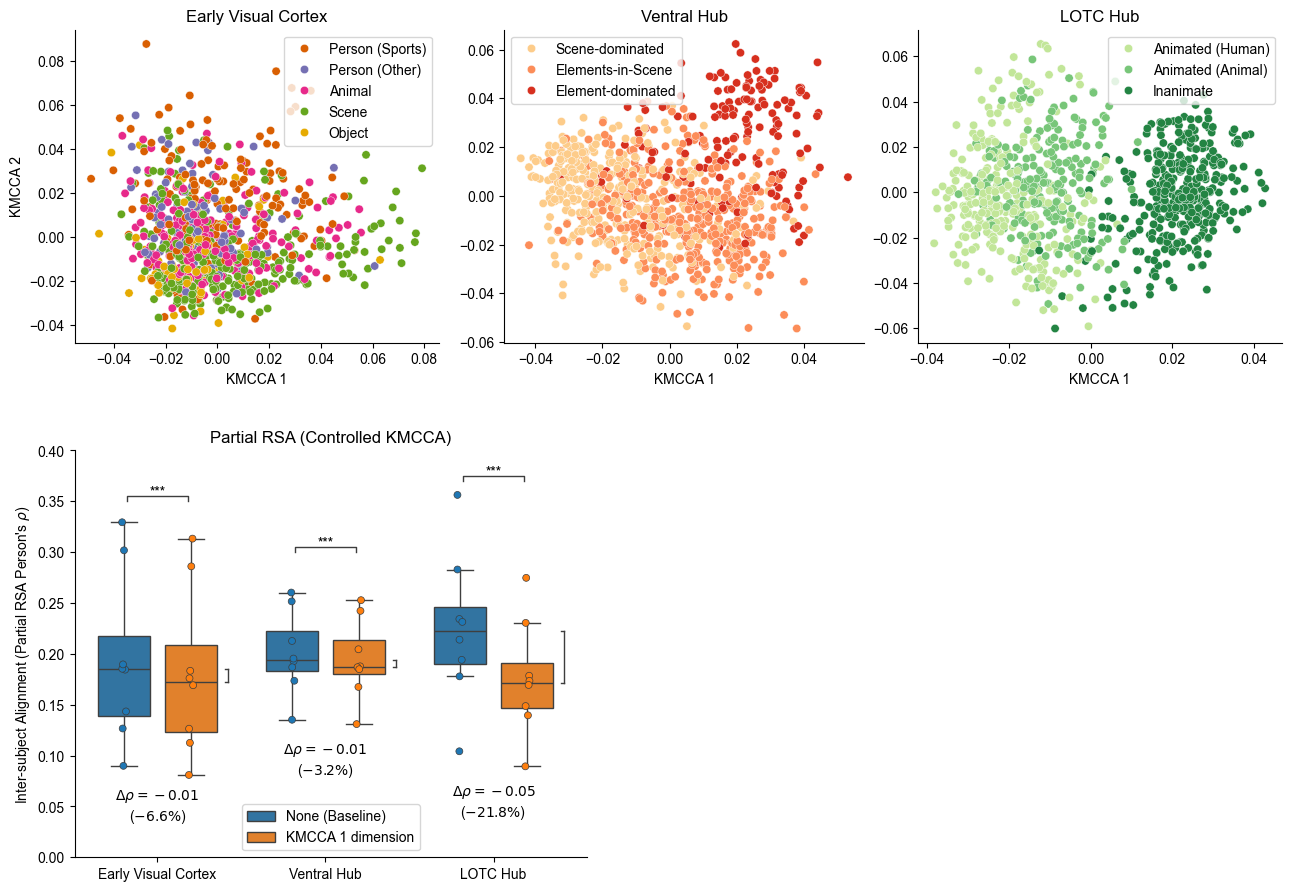

In [298]:
df = pd.read_parquet(filename_projections)
df["biology"] = "Inanimate"
df.loc[df["image_category"].isin(["animal"]), "biology"] = "Animated (Animal)"
df.loc[df["image_category"].isin(["person_action", "sports"]) & df.life, "biology"] = "Animated (Human)"
biology_palette = {
    "Animated (Human)": "C0",
    "Animated (Animal)": "C1",
    "Inanimate": "C2",
}


hue = ["category2", "scene_dominated2", "biology"]
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

df["scene_dominated2"] = df["scene_dominated"]
df.loc[df["category2"] == "object", "scene_dominated2"] = "object-dominated"
df.loc[df.nsd_id.isin(object_dominated), "scene_dominated2"] = "object-dominated"
df.scene_dominated2 = df.scene_dominated2.str.capitalize()
#df.loc[df["category2"] == "scene", "scene_dominated2"] = "scene-dominated"

scene_mapping = {
    "Scene-dominated": "Scene-dominated",
    "Object-in-scene": "Elements-in-Scene",
    "Object-dominated": "Element-dominated",
}
df.scene_dominated2 = df.scene_dominated2.map(scene_mapping)

scene_palette = {
    "Scene-dominated": "C0",
    "Elements-in-Scene": "C1",
    "Element-dominated": "C2",
}

category2_mapping = {
    "sports": "Person (Sports)",
    "person_action": "Person (Other)",
    "animal": "Animal",
    "scene": "Scene",
    "object": "Object",
}
df.category2 = df.category2.map(category2_mapping)
# colorbrewer:accent_5
palettes = {"category2": list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1])),
            "scene_dominated2": list(Colormap('colorbrewer:orrd_4')([0.33, 0.66, 1])),
            "biology":  list(Colormap('colorbrewer:ylgn_4')([0.33, 0.66, 1]))}
hue_order = {"biology": list(biology_palette.keys()),
             "scene_dominated2": list(scene_palette.keys()),
                "category2": list(category2_mapping.values())}

s=0.8
#################################### AQUIIIIIIAQUIIIIIIAQUIIIIIIAQUIIIIIIAQUIIIIIIAQUIIIIII
#fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=False, sharex=False, gridspec_kw={"hspace": 0.25, "wspace": 0.15, "height_ratios": [1.3, 1]})
fig, axes = plt.subplot_mosaic(
    """
    AAABBBCCC
    DDDD.....
    """,
    figsize=(16*s, 11*s),
    sharey=False,
    sharex=False,
    gridspec_kw={"hspace": 0.1},
    layout="constrained",
    height_ratios=[1, 1.3],
    
)

    
#ax1 = axes[0, 0]
ax1 = axes["A"]
df_plot = df.query("roi == 'visual_cortex'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
sns.scatterplot(data=df_plot,x='cca_1', y='cca_2', hue='category2', ax=ax1, palette=palettes["category2"], hue_order=hue_order["category2"],
                lw=0.3)

# Remove legend title

ax1.set_title("Early Visual Cortex", fontsize="large")

ax2 = axes["B"]
df_plot = df.query("roi == 'ventral_hub'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
ax2.set_title("Ventral Hub", fontsize="large")

sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue='scene_dominated2', ax=ax2, palette=palettes["scene_dominated2"], hue_order=hue_order["scene_dominated2"],lw=0.3)



ax3 = axes["C"]
df_plot = df.query("roi == 'dorsal_hub'").copy()
# df_plot["cca_1"] = (df_plot["cca_1"] - df_plot["cca_1"].min()) / (df_plot["cca_1"].max() - df_plot["cca_1"].min())
# df_plot["cca_2"] = (df_plot["cca_2"] - df_plot["cca_2"].min()) / (df_plot["cca_2"].max() - df_plot["cca_2"].min())
sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue='biology', ax=ax3, palette=palettes["biology"], hue_order=hue_order["biology"], lw=0.3)

ax3.set_title("LOTC Hub", fontsize="large")

# for ax in axes.flat[:3]:
#     #ax.set_xticks(np.linspace(0, 1, 5))
#     margin = 0.1
#     #ax.set_xlim(0-margin, 1+margin)
#     #ax.set_yticks(np.linspace(0, 1, 5))
#     #ax.set_ylim(0-margin, 1+margin+0.05)
#     #ax.set_xticklabels([])
#     #ax.set_yticklabels([])
#     ax.set_xlabel("KMCCA 1")
#     ax.set_ylabel("KMCCA 2")



for ax in axes.values():
    sns.despine(ax=ax)

cluster_rois = {
    'Visual Cortex': ['V1', 'V2', 'V3', 'V4'],
    'Ventral Hub': ['PHA1', "PHA2", "PHA3", "VMV1", "VMV2", "VMV3"],
    "Dorsal Hub": ["MT", "MST", "V4t", "FST", "TPOJ2", "TPOJ3"],
}
order = list(cluster_rois.keys())
cluster_rois = {v : k for k, values in cluster_rois.items() for v in values}

df_model_controled = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_controled_joined.parquet")
df_model_controled = df_model_controled.groupby(["model", "roi", "subject", "control"], observed=True).similarity.max().reset_index()
models_info = pd.read_csv("data/models-info.csv")
df_model_controled = df_model_controled.merge(models_info[["model_name", "modality"]], left_on="model", right_on="model_name", how="inner")
df_model_controled = df_model_controled.groupby(["roi", "modality", "control", "subject"], observed=True).similarity.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)[["roi", "name", "mne_name", "area", "area_id"]]
df_model_controled = df_model_controled.merge(df_hcp, on="roi", how="inner")
df_model_controled["cluster"] = df_model_controled["name"].map(cluster_rois).fillna("Other")
df_model_controled_clusters = df_model_controled.query("cluster!='Other'").groupby(["modality", "cluster", "control", "subject"], observed=True).similarity.mean().reset_index()
df_model_controled_clusters

df_controled = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_controled_joined_1.parquet")#.query("control in ['scene', 'biology', 'uncontrolled']")
df_controled = df_controled.query("roi_x == roi_y and subject_i==subject_j").groupby(["roi_x", "control", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled = df_controled.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], left_on="roi_x", right_on="roi", how="inner")
df_controled = df_controled.drop(columns=["roi_x"])
df_controled["cluster"] = df_controled["name"].map(cluster_rois).fillna("Other")
df_controled_glusters = df_controled.query("cluster!='Other'").groupby(["control", "cluster", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled_glusters = df_controled_glusters.rename(columns={"subject_i": "subject"})
df_controled_glusters["modality"] = "intersubject"


df_controled_clusters = pd.concat([df_controled_glusters, df_model_controled_clusters], ignore_index=True)
df_controled_clusters.modality = df_controled_clusters.modality.str.capitalize()

modality_order = ["Intersubject", "Vision", "Language"]
# uncontrolled, dorsal_hub_cca_1, ventral_hub_cca_1, visual_cortex_cca_1
#hue_order = ['uncontrolled', 'visual_cortex_cca_1']
#df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Visual Cortex'").copy()
#df_plot = df_controled_clusters.query("control in @hue_order and modality == 'Language'").copy()
#df_plot.control = df_plot.control.astype(str)
df_plot = df_controled_clusters.query("""modality == 'Intersubject' and 
                            (((cluster == 'Visual Cortex' and control == 'visual_cortex_cca_1')
                            or (cluster == 'Ventral Hub' and control == 'ventral_hub_cca_1')
                            or (cluster == 'Dorsal Hub' and control == 'dorsal_hub_cca_1')
                            ) or (control == 'uncontrolled')
                            )
                            """.replace("\n", " ")).copy()

df_plot.control = df_plot.control.map({"visual_cortex_cca_1": "KMCCA 1 dimension",
                     "ventral_hub_cca_1": "KMCCA 1 dimension",
                     "dorsal_hub_cca_1": "KMCCA 1 dimension",
                     "uncontrolled": "None (Baseline)"})
df_plot


#df_plot_evc = df_plot.copy()
#df_plot.control = df_plot.control.replace({"visual_cortex_cca_1": "KMCCA 1 dimension", "uncontrolled": "None (Baseline)"})
hue_order = ['None (Baseline)', 'KMCCA 1 dimension']


ax4 = axes["D"]




# hue_order = ['uncontrolled', 'ventral_hub_cca_1']
# df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Ventral Hub'").copy()
# df_plot.control = df_plot.control.astype(str)
# df_plot_ventral = df_plot.copy()

# ax5 = axes[1, 1]
# sns.boxplot(data=df_plot, x='modality', y='similarity', hue='control', ax=ax5, order=modality_order, hue_order=hue_order)


# hue_order = ['uncontrolled', 'dorsal_hub_cca_1']
# df_plot = df_controled_clusters.query("control in @hue_order and cluster == 'Dorsal Hub'").copy()
# df_plot.control = df_plot.control.astype(str)
# df_plot_dorsal = df_plot.copy()
# ax6 = axes[1, 2]
# #sns.boxplot(data=df_plot, x='modality', y='similarity', hue='control', ax=ax6, order=modality_order, hue_order=hue_order)

# ax4.set_title("Early Visual Cortex", fontsize="large")
# ax5.set_title("Ventral Hub", fontsize="large")
# ax6.set_title("LOTC Hub", fontsize="large")
# # Remove a5 and a6 legends completely
# ax5.legend_.remove()
# ax6.legend_.remove()
# # Change title of first legend 
# ax4.legend(title="Controlled Variable (Partial RSA)", title_fontsize=9, loc="upper right")

# for ax in axes.flat[3:]:
#     ax.set_xlabel("")
#     ax.set_ylim(-0.04, 0.4)
#     ax.set_ylabel(r"Alignment (RSA Person's $\rho$)")

# ax1.legend(title="Semantic category", loc="upper right",  ncol=1, fontsize=9, title_fontsize=9)
# ax2.legend(title="Scene-Object gradient", loc="upper left",  ncol=1, fontsize=9, title_fontsize=9)
# ax3.legend(title="Biological presence ", loc="upper right",  ncol=1, fontsize=9, title_fontsize=9)


# df_filtered = pd.concat([df_plot_evc, df_plot_ventral, df_plot_dorsal], ignore_index=True)
# df_filtered.control = df_filtered.control.replace({"visual_cortex_cca_1": "controlled",
#                              "ventral_hub_cca_1": "controlled",
#                             "dorsal_hub_cca_1": "controlled",
#                             })

# df_filtered_controled = df_filtered.query("control == 'controlled'").copy().rename(columns={"similarity": "partial_rsa"}).drop(columns=["control"])
# df_filtered_uncontroled = df_filtered.query("control == 'uncontrolled'").copy().rename(columns={"similarity": "rsa"}).drop(columns=["control"])

# df_filtered = df_filtered_controled.merge(df_filtered_uncontroled, on=["cluster", "modality", "subject"])
# df_filtered


# # By each cluster, modality and using subject for a paired t-test
# from scipy import stats
comparisons = df_filtered.groupby(["cluster", "modality"]).apply(lambda x: stats.ttest_rel(x["rsa"], x["partial_rsa"]), include_groups=False).reset_index()

comparisons["p_value"] = comparisons[0].apply(lambda x: x.pvalue)
comparisons["t_statistic"] = comparisons[0].apply(lambda x: x.statistic)
comparisons = comparisons.drop(columns=[0])

# # Apply 
# from statsmodels.stats.multitest import multipletests
# # Use family-wise error rate correction method
# method = "bonferroni"
# comparisons = comparisons.query("modality != 'Language' or cluster != 'Visual Cortex'").copy()
# comparisons["p_value_corrected"] = multipletests(comparisons["p_value"], method=method)[1]
# comparisons["apa_significance"] = comparisons["p_value_corrected"].apply(lambda x: "ns" if x > 0.05 else ("*" if x < 0.05 and x >= 0.01 else ("**" if x < 0.01 and x >= 0.001 else "***")))

# display(comparisons)

# #for cluster in ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]:

# w = 0.21
# h = 0.005
# add_pvalue_bracket(ax=ax4, x1=0-w, x2=0+w, y=0.35, height=h, text="***")
# add_pvalue_bracket(ax=ax4, x1=1-w, x2=1+w, y=0.19, height=h, text="***") # 0.000001	
# # add_pvalue_bracket(ax=ax4, x1=2-w, x2=2+w, y=0.10, height=h, text="***") # 0.000047	

# add_pvalue_bracket(ax=ax5, x1=0-w, x2=0+w, y=0.3, height=h, text="**") # 0.001698	
# add_pvalue_bracket(ax=ax5, x1=1-w, x2=1+w, y=0.19, height=h, text="***") # 0.000431	
# add_pvalue_bracket(ax=ax5, x1=2-w, x2=2+w, y=0.10, height=h, text="***") # 0.001060	

# add_pvalue_bracket(ax=ax6, x1=0-w, x2=0+w, y=0.38, height=h, text="**") # 0.001751	
# add_pvalue_bracket(ax=ax6, x1=1-w, x2=1+w, y=0.22, height=h, text="***") # 0.000145	
# add_pvalue_bracket(ax=ax6, x1=2-w, x2=2+w, y=0.25, height=h, text="***") # 0.000067	



for ax in list(axes.values())[:3]:
    ax.set_xlabel("KMCCA 1")
    ax.set_ylabel("")
    # Remove legend title
    ax.legend(title="")
ax1.set_ylabel("KMCCA 2")


cluster_order = ['Early Visual Cortex', 'Ventral Hub', 'LOTC Hub']
df_plot.cluster = df_plot.cluster.replace({'Dorsal Hub': "LOTC Hub", "Visual Cortex": "Early Visual Cortex"})


sns.boxplot(data=df_plot, x='cluster', y='similarity', hue='control', ax=ax4, order=cluster_order, hue_order=hue_order,  gap=0.23, showfliers=False)
# Add points with jitter
sns.stripplot(data=df_plot, x='cluster', y='similarity', hue='control', ax=ax4, order=cluster_order, 
    hue_order=hue_order, alpha=1, marker="o", size=5, edgecolor=(0.24, 0.24, 0.24), linewidth=0.5, jitter=0.03, legend=False, dodge=True)
              
for i, cluster in enumerate(cluster_order):
    am = df_plot.query("cluster == @cluster and control =='None (Baseline)'").similarity.mean()
    bm = df_plot.query("cluster == @cluster and control != 'None (Baseline)'").similarity.mean()
    a = df_plot.query("cluster == @cluster and control =='None (Baseline)'").similarity.median()
    b = df_plot.query("cluster == @cluster and control !='None (Baseline)'").similarity.median()
    mininimun = df_plot.query("cluster == @cluster and control =='None (Baseline)'").similarity.min()
    abs_diff = (bm-am)
    rel_diff = abs_diff / max(am, bm)
    print(f"{cluster} - Absolute difference: {abs_diff:.2f}, Relative difference: {100*rel_diff:.1f}")
    #print(f"{cluster} - Absolute difference: {
    c = 0.42 + i
    w = 0.02
    w2 = 0.15
    ax4.plot([c, c], [a, b], color=(0.24, .24, .24), lw=1)
    ax4.plot([c-w, c], [a, a], color=(0.24, .24, .24), lw=1)
    ax4.plot([c-w, c], [b, b], color=(0.24, .24, .24), lw=1)
    # ax4.plot([i-w2, i+w2], [a, b], color=(0.24, .24, .24), lw=1, ls='-')
    
    t = 0 if i!=2 else 0.01
    ax4.text(i,mininimun -0.04-t, f"$\\Delta\\rho = {abs_diff:.2f}$\n(${100*rel_diff:.1f} \%$)", ha='center', va='center', fontsize=10)
    #ax4.text(c+ 0.02, (a+b)/2, f"$\\Delta\\rho$", ha='left', va='center', fontsize=10)
ax4.set_ylim(0.0, None)
# lower center
ax4.legend(loc="lower center", title="")
ax4.set_title("Partial RSA (Controlled KMCCA)", fontsize="large")
ax4.set_xlabel("")
ax4.set_ylabel(r"Inter-subject Alignment (Partial RSA Person's $\rho$)")
ax4.set_ylim(0,0.4)
w = 0.18
add_pvalue_bracket(ax=ax4, x1=0-w, x2=0+w, y=0.35, height=h, text="***")
add_pvalue_bracket(ax=ax4, x1=1-w, x2=1+w, y=0.3, height=h, text="***") # 0.000001	
add_pvalue_bracket(ax=ax4, x1=2-w, x2=2+w, y=0.37, height=h, text="***") # 0.000047	
comparisons = comparisons.query("cluster == 'Dorsal Hub'")
comparisons["p_value_corrected"] = multipletests(comparisons["p_value"], method="bonferroni")[1]
comparisons["apa_significance"] = comparisons["p_value_corrected"].apply(lambda x: "ns" if x > 0.05 else ("*" if x < 0.05 and x >= 0.01 else ("**" if x < 0.01 and x >= 0.001 else "***")))


fig.savefig(output / "figure_dimensions.pdf", bbox_inches="tight", transparent=True)

In [299]:
output

PosixPath('figure_dimensions')

In [278]:
df_plot2 = df_plot.copy()
df_diffs = df_plot2.query("control == 'None (Baseline)'")[["cluster", "similarity", "subject", "modality"]].merge(
    df_plot2.query("control != 'None (Baseline)'")[["cluster", "similarity", "subject"]].rename(columns={"similarity": "partial_rsa"}), 
    on=["cluster", "subject"])
df_diffs["abs_diff"] = df_diffs["partial_rsa"] - df_diffs["similarity"]
df_diffs["rel_diff"] = df_diffs["abs_diff"] / df_diffs["partial_rsa"]
df_diffs

# import ttest
from statsmodels.stats.weightstats import ttest_ind
# Import ttest_rel (not ttest_ind)
from scipy.stats import ttest_rel

lotc = df_diffs.query("cluster == 'LOTC Hub' and modality == 'Intersubject'")
ventral = df_diffs.query("cluster == 'Ventral Hub' and modality == 'Intersubject'")
visual = df_diffs.query("cluster == 'Early Visual Cortex' and modality == 'Intersubject'")

res_lotc_vs_visual = ttest_rel(lotc["abs_diff"], visual["abs_diff"])#, usevar='unequal')
res_lotc_vs_ventral = ttest_rel(lotc["abs_diff"], ventral["abs_diff"])#, usevar='unequal')

print(f"LOTC vs Visual: t-statistic={res_lotc_vs_visual.statistic:.3f}, p-value={3*res_lotc_vs_visual.pvalue:.3f}")
print(f"LOTC vs Ventral: t-statistic={res_lotc_vs_ventral.statistic:.3f}, p-value={3*res_lotc_vs_ventral.pvalue:.3f}")

LOTC vs Visual: t-statistic=-6.165, p-value=0.001
LOTC vs Ventral: t-statistic=-6.517, p-value=0.001


In [ ]:
print(list(df_controled_clusters.cluster.unique()))
list(df_controled_clusters.control.unique())


['Dorsal Hub', 'Ventral Hub', 'Visual Cortex']


,control,cluster,subject,similarity,modality
48,KMCCA 1 dimension,Dorsal Hub,1,0.178451,Intersubject
49,KMCCA 1 dimension,Dorsal Hub,2,0.230430,Intersubject
50,KMCCA 1 dimension,Dorsal Hub,3,0.173475,Intersubject
51,KMCCA 1 dimension,Dorsal Hub,4,0.169404,Intersubject
52,KMCCA 1 dimension,Dorsal Hub,5,0.274716,Intersubject
53,KMCCA 1 dimension,Dorsal Hub,6,0.139561,Intersubject
54,KMCCA 1 dimension,Dorsal Hub,7,0.148661,Intersubject
55,KMCCA 1 dimension,Dorsal Hub,8,0.089410,Intersubject
144,None (Baseline),Dorsal Hub,1,0.234258,Intersubject
145,None (Baseline),Dorsal Hub,2,0.282915,Intersubject


In [ ]:
df_controled_clusters.control

,control,cluster,subject,similarity,modality
0,biology,Dorsal Hub,1,0.209736,Intersubject
1,biology,Dorsal Hub,2,0.263255,Intersubject
2,biology,Dorsal Hub,3,0.195221,Intersubject
3,biology,Dorsal Hub,4,0.204787,Intersubject
4,biology,Dorsal Hub,5,0.322893,Intersubject
...,...,...,...,...,...
931,visual_cortex_cca_2,Visual Cortex,4,0.097776,Vision
932,visual_cortex_cca_2,Visual Cortex,5,0.103177,Vision
933,visual_cortex_cca_2,Visual Cortex,6,0.095217,Vision
934,visual_cortex_cca_2,Visual Cortex,7,0.076346,Vision


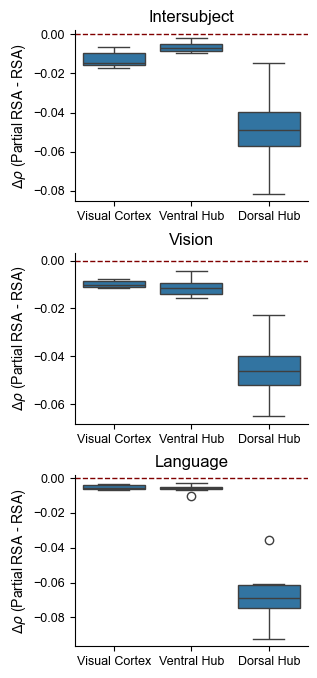

In [40]:
df_filtered["difference"] = df_filtered["partial_rsa"] - df_filtered["rsa"] 

fig, axes = plt.subplots(3, 1, figsize=(3, 8), gridspec_kw={"hspace": 0.3, "height_ratios": [1, 1, 1]})

ax= axes[0]
modality = "Intersubject"

for ax, modality in zip(axes, ["Intersubject", "Vision", "Language"]):
    ax.set_title(modality, fontsize="large")
    sns.boxplot(data=df_filtered.query("modality==@modality"), y='difference', x="cluster", order=["Visual Cortex", "Ventral Hub", "Dorsal Hub"], ax=ax, legend=False)
    ax.set_ylabel("$\Delta\\rho$ (Partial RSA - RSA)")
    ax.set_xlabel("")
    sns.despine(ax=ax)
    # Set fontsize small
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.axhline(0, color='maroon', linestyle="--", lw=1, zorder=-100)



In [234]:
df_filtered_means = df_filtered.groupby(["cluster", "modality"]).agg({'rsa': 'mean', 'partial_rsa': 'mean'}).reset_index()
df_filtered_means = df_filtered_means.query("modality != 'Language' or cluster != 'Visual Cortex'").copy()
df_filtered_means["change_ratio"] = (df_filtered_means["partial_rsa"] - df_filtered_means["rsa"]) / df_filtered_means["rsa"]
df_filtered_means["abs_change"] = df_filtered_means["partial_rsa"] - df_filtered_means["rsa"]
df_filtered_means.cluster = df_filtered_means.cluster.replace({"Dorsal Hub": "LOTC Hub"})
df_filtered_means

,cluster,modality,rsa,partial_rsa,change_ratio,abs_change
0,LOTC Hub,Intersubject,0.224364,0.175514,-0.217730,-0.048851
1,LOTC Hub,Language,0.147945,0.080713,-0.454435,-0.067231
2,LOTC Hub,Vision,0.130774,0.085390,-0.347045,-0.045385
3,Ventral Hub,Intersubject,0.201023,0.194683,-0.031537,-0.006340
4,Ventral Hub,Language,0.021994,0.016166,-0.264974,-0.005828
5,Ventral Hub,Vision,0.107331,0.096139,-0.104278,-0.011192
6,Visual Cortex,Intersubject,0.193809,0.180947,-0.066365,-0.012862
8,Visual Cortex,Vision,0.117324,0.107403,-0.084561,-0.009921


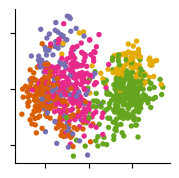

In [260]:
df = pd.read_parquet(filename_projections)
df["biology"] = "Inanimate"
df.loc[df["image_category"].isin(["animal"]), "biology"] = "Animated (Animal)"
df.loc[df["image_category"].isin(["person_action", "sports"]) & df.life, "biology"] = "Animated (Human)"
biology_palette = {
    "Animated (Human)": "C0",
    "Animated (Animal)": "C1",
    "Inanimate": "C2",
}


hue = ["category2", "scene_dominated2", "biology"]
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

df["scene_dominated2"] = df["scene_dominated"]
df.loc[df["category2"] == "object", "scene_dominated2"] = "object-dominated"
df.loc[df.nsd_id.isin(object_dominated), "scene_dominated2"] = "object-dominated"
df.scene_dominated2 = df.scene_dominated2.str.capitalize()
#df.loc[df["category2"] == "scene", "scene_dominated2"] = "scene-dominated"

scene_mapping = {
    "Scene-dominated": "Scene-dominated",
    "Object-in-scene": "Elements-in-Scene",
    "Object-dominated": "Element-dominated",
}
df.scene_dominated2 = df.scene_dominated2.map(scene_mapping)

scene_palette = {
    "Scene-dominated": "C0",
    "Elements-in-Scene": "C1",
    "Element-dominated": "C2",
}

category2_mapping = {
    "sports": "Person (Sports)",
    "person_action": "Person (Other)",
    "animal": "Animal",
    "scene": "Scene",
    "object": "Object",
}
df.category2 = df.category2.map(category2_mapping)
# colorbrewer:accent_5
palettes = {"category2": list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1])),
            "scene_dominated2": list(Colormap('colorbrewer:orrd_4')([0.33, 0.66, 1])),
            "biology":  list(Colormap('colorbrewer:ylgn_4')([0.33, 0.66, 1]))}
hue_order = {"biology": list(biology_palette.keys()),
             "scene_dominated2": list(scene_palette.keys()),
                "category2": list(category2_mapping.values())}


fig, ax = plt.subplots(figsize=(2, 2))
df_plot = df.query("roi == 'dorsal_hub'").copy()
var = "category2"
sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue=var, ax=ax, palette=palettes[var], hue_order=hue_order[var], linewidth=0, s=15)

sns.despine(ax=ax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.get_legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")

fig.savefig(output / "figure_dimensions_projections_kmcca_dorsal_hub_sketch.pdf", bbox_inches="tight", dpi=300, transparent=True)

# Extended analysis

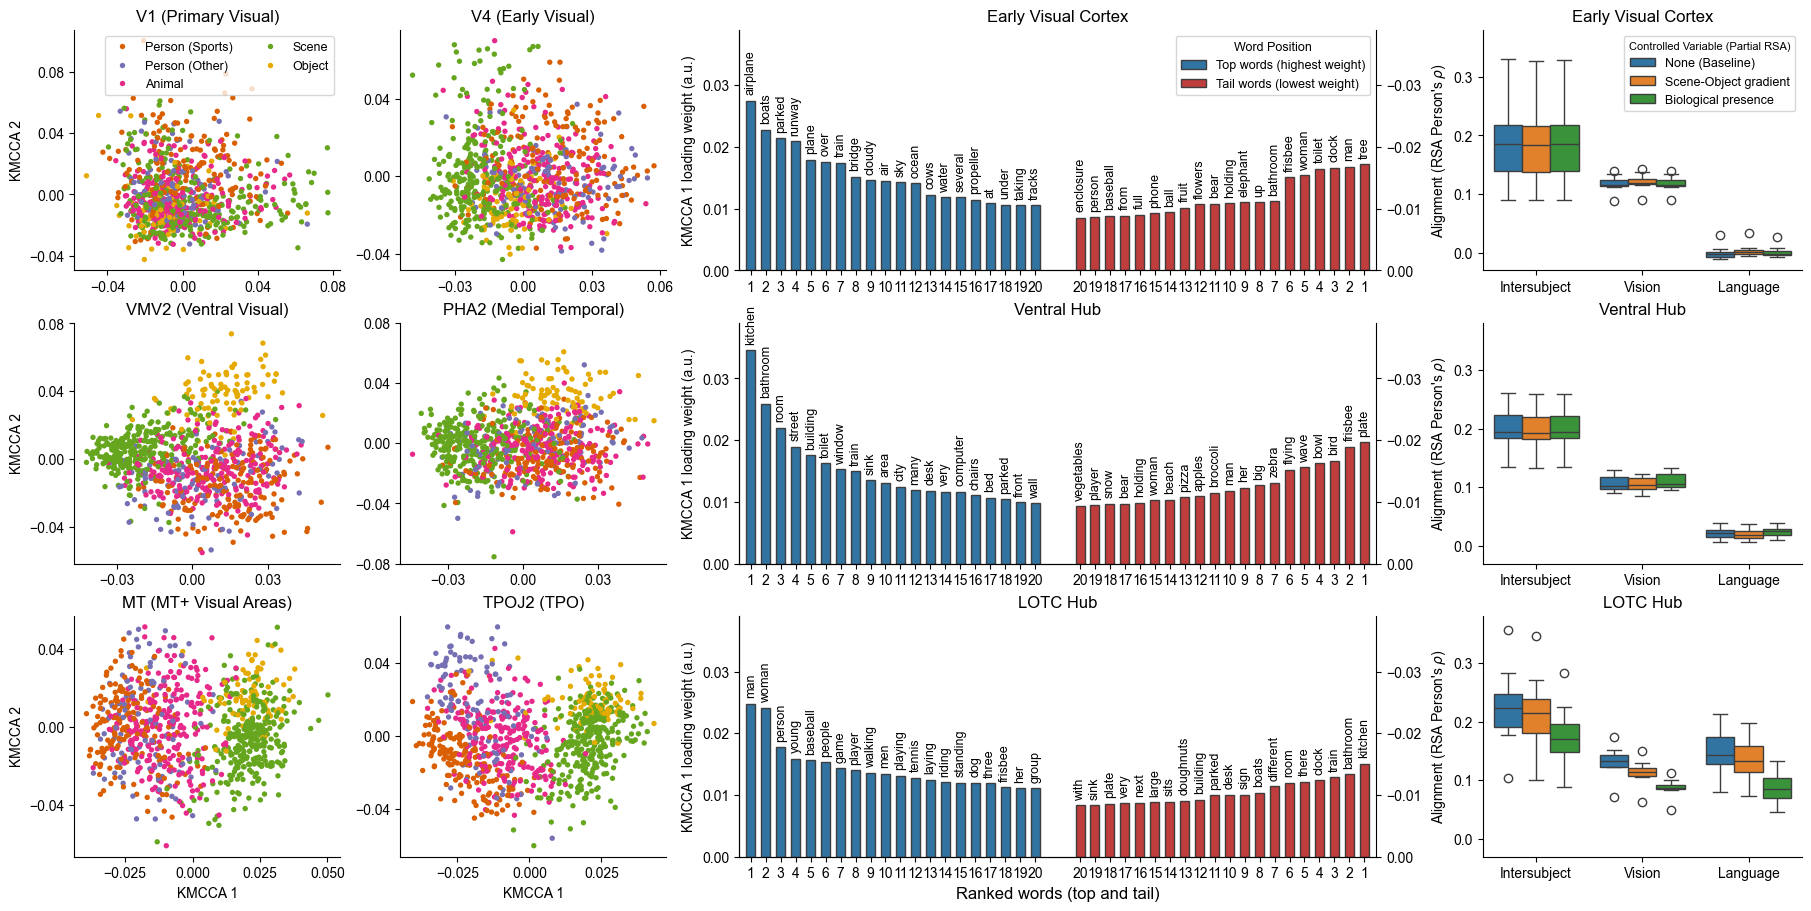

In [590]:
# Generate a mosaic with 
#
# A B C J M
# D E F K N
# G H I L O

hcp = pd.read_csv(filename_hcp)[["roi", "name", "mne_name", "area", "area_id"]].query("roi <= 180")
hcp = hcp.set_index("name")

mosaic_pannel = [
    ["A", "B", "J", "G"],
    ["C", "D", "K", "H"],
    ["E", "F", "L", "I"],
]

fig, axes = plt.subplot_mosaic(mosaic_pannel, figsize=(18, 9), width_ratios=[0.5, 0.5, 1.2, 0.6], height_ratios=[1, 1, 1], sharex=False, sharey=False, layout="constrained")#, gridspec_kw={"hspace": 0.2, "wspace": 0.2})
# Set the titles of the axes
# for panel in ["A", "B", "C", "D", "G", "H"]:
#     ax = axes[panel]
#     ax.set_box_aspect(1)

for ax in axes.values():
    ax.set_xlabel("")
    ax.set_ylabel("")
    sns.despine(ax=ax)



# Scatters

df = pd.read_parquet(filename_projections)
df["biology"] = "Inanimate"
df.loc[df["image_category"].isin(["animal"]), "biology"] = "Animated (Animal)"
df.loc[df["image_category"].isin(["person_action", "sports"]) & df.life, "biology"] = "Animated (Human)"
biology_palette = {
    "Animated (Human)": "C0",
    "Animated (Animal)": "C1",
    "Inanimate": "C2",
}


hue = ["category2", "scene_dominated2", "biology"]
rois = ["visual_cortex", "ventral_hub", "dorsal_hub"]

df["scene_dominated2"] = df["scene_dominated"]
df.loc[df["category2"] == "object", "scene_dominated2"] = "object-dominated"
df.loc[df.nsd_id.isin(object_dominated), "scene_dominated2"] = "object-dominated"
df.scene_dominated2 = df.scene_dominated2.str.capitalize()
#df.loc[df["category2"] == "scene", "scene_dominated2"] = "scene-dominated"

scene_mapping = {
    "Scene-dominated": "Scene-dominated",
    "Object-in-scene": "Elements-in-Scene",
    "Object-dominated": "Element-dominated",
}
df.scene_dominated2 = df.scene_dominated2.map(scene_mapping)

scene_palette = {
    "Scene-dominated": "C0",
    "Elements-in-Scene": "C1",
    "Element-dominated": "C2",
}

category2_mapping = {
    "sports": "Person (Sports)",
    "person_action": "Person (Other)",
    "animal": "Animal",
    "scene": "Scene",
    "object": "Object",
}
df.category2 = df.category2.map(category2_mapping)
# colorbrewer:accent_5
palettes = {"category2": list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1])),
            "scene_dominated2": list(Colormap('colorbrewer:orrd_4')([0.33, 0.66, 1])),
            "biology":  list(Colormap('colorbrewer:ylgn_4')([0.33, 0.66, 1]))}
hue_order = {"biology": list(biology_palette.keys()),
             "scene_dominated2": list(scene_palette.keys()),
                "category2": list(category2_mapping.values())}

# array(['MT', 'MST', 'V4t', 'FST', 'TPOJ2', 'TPOJ3', 'PHA1', 'PHA2',
#       'PHA3', 'VMV1', 'VMV2', 'VMV3', 'V1', 'V2', 'V3', 'V4',

for roi, panel in [("V1", "A"), ("V4", "B"), ("VMV2", "C"), ("PHA2", "D"), ("MT", "E"), ("TPOJ2", "F")]:
    ax = axes[panel]
    df_plot = df.query("roi == @roi").copy()
    if roi == "PHA2":
        df_plot["cca_2"] *= -1
    var = "category2"
    sns.scatterplot(data=df_plot, x='cca_1', y='cca_2', hue=var, ax=ax, palette=palettes[var], hue_order=hue_order[var], linewidth=0, s=15)
    #ax.set_title(f"{roi} (Early Visual Cortex)", fontsize="large")
    #ax.set_xticklabels([])
    if roi != "V1":
        #ax.set_yticklabels([])
        ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    area = hcp.loc[roi, "area"].replace(" (V2-4)", "")
    ax.set_title(f"{roi} ({area})", fontsize="large")
    

df_lotc = df.query("roi == 'dorsal_hub'").copy()

df_words = pd.read_parquet("/Users/pablomm/Desktop/top_words.parquet")
df_words["abs_score"] = df_words["score"].abs()
top = 20
space = 3



for panel, roi in [("J", "EVC"), ("K", "Ventral"), ("L", "LOTC")]:
    ax = axes[panel]
    df_words_top = df_words.query("hub==@roi").sort_values("score", ascending=False).head(top)
    df_words_top = df_words_top.reset_index(drop=True).reset_index().rename(columns={"index": "rank"})
    df_words_top["rank"] = df_words_top["rank"] + 1
    df_words_top["position"] = "top"
    df_words_bottom = df_words.query("hub==@roi").sort_values("score", ascending=False).tail(top)
    df_words_bottom = df_words_bottom.reset_index(drop=True).reset_index().rename(columns={"index": "rank"})
    df_words_bottom["rank"] = df_words_bottom["rank"] + space + top
    df_words_bottom["position"] = "tail"
    
    df_empty = pd.DataFrame({"rank": range(top+1, top+space)})
    df_empty["position"] = "space"
    df_empty["token"] = ""

    df_words_top = pd.concat([df_words_top, df_empty, df_words_bottom], ignore_index=True)
    df_words_top


    sns.barplot(data=df_words_top, x="rank", y="abs_score", hue="position", ax=ax,  edgecolor=(0.24, 0.24, 0.24), dodge=False, errorbar=None, width=0.6, capsize=0.1, lw=1, legend=roi=='EVC', palette={"top": "C0", "tail": "C3", "space": "C1"}, hue_order=["top", "space", "tail"])
    
    # Legend remove title and remove space category
    if roi == "EVC":
        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[0], handles[2]]  # Keep only "top" and "tail"
        labels = ["Top words (highest weight)", "Tail words (lowest weight)"]
        ax.legend(handles, labels, title="Word Position", title_fontsize=9, loc="upper right", fontsize=9)

    



    # Add "token" text to the bars
    for i, row in df_words_top.iterrows():
        ax.text(row["rank"] -1, row["abs_score"] + 0.001, row["token"], ha="center", va="bottom", fontsize=9, rotation=90)


    ax.set_xlim(-0.8, top + space + top - 1 -0.2)
    #ax.set_xticks(np.arange(0, top + space + top, 1))
    ax.set_xticks(np.concat([np.arange(0, top), np.arange(top + space-1, top + space + top - 1)]))

    order = 1 + np.arange(0, top)
    ax.set_xticklabels(np.concat([order, order[::-1]]), fontsize=10)
    ax2 = ax.twinx()
    ax.set_ylim(0, 0.039)
    ax2.set_ylim(-0.039, 0)
    ax2.invert_yaxis()
    ax.set_yticks([0, 0.01, 0.02, 0.03])
    ax2.set_yticks([0, -0.01, -0.02, -0.03])
    sns.despine(ax=ax2, left=False, right=False)
    ax.set_xlabel("")
    ax.set_ylabel("KMCCA 1 loading weight (a.u.)", fontsize=10)
    #ax2.set_ylabel("KMCCA 1 loading weight (a.u.)", fontsize=12)

axes["J"].set_title("Early Visual Cortex", fontsize="large")
axes["K"].set_title("Ventral Hub", fontsize="large")
axes["L"].set_title("LOTC Hub", fontsize="large")
axes["L"].set_xlabel("Ranked words (top and tail)", fontsize=12)
axes["D"].set_ylim(-0.08, 0.08)

for panel in ["A", "B", "C", "D", "E", "F"]:
    axes[panel].yaxis.set_major_locator(plt.MaxNLocator(4))
    axes[panel].xaxis.set_major_locator(plt.MaxNLocator(4))

for panel in ["A", "C", "E"]:
    axes[panel].set_ylabel("KMCCA 2")

axes["E"].set_xlabel("KMCCA 1")
axes["F"].set_xlabel("KMCCA 1")



df_model_controled = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_controled_joined.parquet")
df_model_controled = df_model_controled.groupby(["model", "roi", "subject", "control"], observed=True).similarity.max().reset_index()
models_info = pd.read_csv("data/models-info.csv")
df_model_controled = df_model_controled.merge(models_info[["model_name", "modality"]], left_on="model", right_on="model_name", how="inner")
df_model_controled = df_model_controled.groupby(["roi", "modality", "control", "subject"], observed=True).similarity.mean().reset_index()
df_hcp = pd.read_csv(filename_hcp)[["roi", "name", "mne_name", "area", "area_id"]]
df_model_controled = df_model_controled.merge(df_hcp, on="roi", how="inner")
df_model_controled["cluster"] = df_model_controled["name"].map(cluster_rois).fillna("Other")
df_model_controled_clusters = df_model_controled.query("cluster!='Other'").groupby(["modality", "cluster", "control", "subject"], observed=True).similarity.mean().reset_index()
df_model_controled_clusters

df_controled = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_controled_joined_1.parquet")#.query("control in ['scene', 'biology', 'uncontrolled']")
df_controled = df_controled.query("roi_x == roi_y and subject_i==subject_j").groupby(["roi_x", "control", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled = df_controled.merge(df_hcp[["roi", "name", "mne_name", "area", "area_id"]], left_on="roi_x", right_on="roi", how="inner")
df_controled = df_controled.drop(columns=["roi_x"])
df_controled["cluster"] = df_controled["name"].map(cluster_rois).fillna("Other")
df_controled_glusters = df_controled.query("cluster!='Other'").groupby(["control", "cluster", "subject_i"], observed=True).similarity.mean().reset_index()
df_controled_glusters = df_controled_glusters.rename(columns={"subject_i": "subject"})
df_controled_glusters["modality"] = "intersubject"


df_controled_clusters = pd.concat([df_controled_glusters, df_model_controled_clusters], ignore_index=True)
df_controled_clusters.modality = df_controled_clusters.modality.str.capitalize()
df_controled_clusters



# Make a barplot with: data=df_controled_clusters, x="modality" row="cluster" y="similarity", hue="control"
row_order = ["Intersubject", "Vision", "Language"]
cluster_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
controls = ["visual_cortex_cca_1", "ventral_hub_cca_1", "dorsal_hub_cca_1"]

# Rename controls:
control_names = {
    "uncontrolled": "None (Baseline)",
    "visual_cortex_cca_1": "Visual Cortex KMCCA 1",
    "ventral_hub_cca_1": "Ventral Hub KMCCA 1",
    "dorsal_hub_cca_1": "Dorsal Hub KMCCA 1",
}
modality_names = {
    "Intersubject": "Intersubject",
    "Vision": "Vision Models",
    "Language": "Language Models",
}


hub = "Ventral Hub"
control = ['uncontrolled', 'biology_binary', 'scene']
control_names = {
    "uncontrolled": "None (Baseline)",
    "scene": "Scene-Object gradient",
    "biology_binary": "Biological presence",
}
order = ['Intersubject', 'Vision', 'Language']


axes_last = (axes["G"], axes["H"], axes["I"])

for i,hub in enumerate(['Visual Cortex', 'Ventral Hub', 'Dorsal Hub']):


    df_controled = df_controled_clusters.query("cluster==@hub and control in @control").copy()
    df_controled.control = df_controled.control.astype(str)
    df_controled.control = df_controled.control.replace(control_names)
    hue_order = list(control_names.values())
    ax = axes_last[i]
    sns.boxplot(data=df_controled, x='modality', y='similarity', hue='control', ax=ax, hue_order=hue_order, order=order, legend=i==0)
    if i == 0:
        ax.legend(title="Controlled Variable (Partial RSA)", title_fontsize=8, loc="upper right", fontsize=9)
    sns.despine(ax=ax)
    ax.set_ylim(-0.03, 0.38)
    name_hub = hub.replace("Dorsal", "LOTC").replace("Visual", "Early Visual")
    ax.set_title(f"{name_hub}", fontsize="large")
    ax.set_xlabel("")
    ax.set_ylabel(r"Alignment (RSA Person's $\rho$)", fontsize=10)


axes["A"].legend(title="", loc="upper right",  ncol=2, fontsize=9)
#fig.savefig(output / "figure_dimensions_projections_kmcca_hubs_supl.svg", bbox_inches="tight", transparent=True)




In [610]:
df_lotc["scene_n"] = df_lotc.scene_dominated2.map(
    {'Scene-dominated': 2, 
     'Elements-in-Scene': 1, 
     'Element-dominated': 0}
)
df_lotc["biology_n"] = df_lotc.biology.map(
    {'Animated (Human)': 1, 
     'Animated (Animal)': 1, 
     'Inanimate': 0}
)


import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# --- 1. Create Sample Data ---
# This mimics your data structure. Replace this with your actual data arrays.
# Let's assume you have 1000 stimuli.

# Scene-Object Gradient: 0=Object, 1=Element-in-Scene, 2=Scene-dominated
scene_gradient = df_lotc["scene_n"].values

# Biological Presence: 0=Inanimate, 1=Animate
biological_presence = df_lotc["biology_n"].values

# --- 2. Create a Contingency Table ---
# This table counts how many times each pair of categories occurs together.
contingency_table = pd.crosstab(scene_gradient, biological_presence)

print("Contingency Table:")
print(contingency_table)
print("\n" + "="*30 + "\n")

# --- 3. Perform the Chi-Squared Test ---
# The chi2_contingency function takes the contingency table as input.
chi2_stat, p_val, dof, expected_freq = chi2_contingency(contingency_table)

# --- 4. Print and Interpret the Results ---
print(f"Chi-squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")

Contingency Table:
col_0    0    1
row_0          
0      101   60
1       70  331
2      208  137


Chi-squared Statistic: 175.1806
P-value: 9.120300822439282e-39
Degrees of Freedom: 2


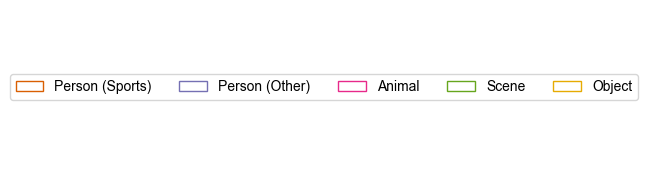

In [580]:
from matplotlib import patches as mpatches
handles, labels = [], []
fig, ax = plt.subplots(figsize=(2, 2))

categories = category2_mapping.keys()
colors = list(Colormap('colorbrewer:dark2_6')([0.2, 0.4, 0.6, 0.8, 1]))
for category, color in zip(categories, colors):
    handles.append(mpatches.Patch(facecolor="white", edgecolor=color, linewidth=1, label=category2_mapping[category]))
ax.legend(handles=handles, title="", loc="center", ncol=6)
ax.axis('off')
fig.savefig(output / "figure_dimensions_projections_kmcca_legend_category.pdf", bbox_inches="tight", transparent=True)



In [570]:
output

PosixPath('figure_dimensions')